### Deep Learning  Assignment
**by- ed24s401**

### ANSWER 1

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

In [16]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ed24s401 (ed24s401-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


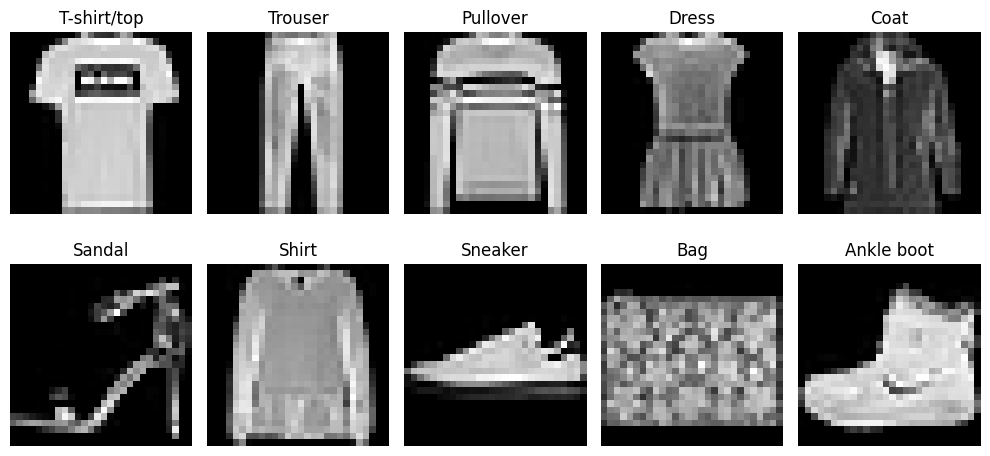

In [ ]:

wandb.init(project='fashion-MNIST dataset', name='fashion-MNIST samples')
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_lbs=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fig, axes=plt.subplots(2,5, figsize=(10,5))
axes=axes.flatten()
marked_img=[]

for i in range(10):
    idx=np.where(y_train ==i)[0][0]
    axes[i].imshow(x_train[idx], cmap='gray')
    axes[i].set_title(class_lbs[i])
    axes[i].axis('off')
    marked_img.append(wandb.Image(x_train[idx], caption=class_lbs[i]))

plt.tight_layout() 
plt.show()
#logging figure to wandb
wandb.log({"fashion-MNIST samples": marked_img})
wandb.finish()



In [7]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
#loading the dataset
(x_train_full, y_train_full), (x_test,y_test)=fashion_mnist.load_data()
 
# normalize images
x_train_full=x_train_full.reshape(x_train_full.shape[0], -1)/255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
#shuffle dataset
np.random.seed(42)
indices=np.arange(x_train_full.shape[0])
np.random.shuffle(indices)

x_train_full, y_train_full=x_train_full[indices], y_train_full[indices]

# splitting the dataset into training(85%) and validation(15%)
train_size=int(.85*len(x_train_full))

x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

#converting truth(y) into one hot vector
t_classes=10
y_train_1h=np.eye(t_classes)[y_train]
y_val_1h=np.eye(t_classes)[y_val]
y_test_1h=np.eye(t_classes)[y_test]
# print(len(x_test))

# print(f"Train set: {x_train.shape}, Validation set: {x_val.shape}, Test set: {x_test.shape}") #Train set: (51000, 784), Validation set: (9000, 784), Test set: (10000, 784)
# print(f"\n{y_train_1h.shape},  {y_val_1h.shape}") #(51000, 10), (9000, 10)



### ANSWER 2.

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer

In [4]:

class feed_forward_NN:

    def __init__(self, layers):
        self.layers=layers
        self.weights=[]
        self.biases=[]
        self.layer_n=len(layers)

        for i in range(self.layer_n-1):
            w=np.random.randn(self.layers[i],self.layers[i+1])*np.sqrt(2/self.layers[i]) #size(self.layers[i] x self.layers[i+1])
            b=np.zeros((1,self.layers[i+1])) #size(self.layers[i] x self.layers[i+1])
            self.weights.append(w)
            self.biases.append(b)

    def sigmoid(self,x):
        return 1/ (1+np.exp(-np.clip(x, -500, 500)))
    
    def softmax(self, x):
        exp_x=np.exp(x-np.max(x, axis=1, keepdims=True))
        return exp_x/np.sum(exp_x, axis=1, keepdims=True)
        
    def sig_derivative(self, x):
        return x*(1-x)
    
    def forward_pass(self,x):
        self.h=[x]
        for i in range(self.layer_n-2):
            a=np.dot(self.h[i], self.weights[i])+ self.biases[i]
            h=self.sigmoid(a)
            self.h.append(h)
        #Output_layer  _using_softmax
        a_out=np.dot(self.h[-1],self.weights[-1]) +self.biases[-1]
        h_out=self.softmax(a_out)
        self.h.append(h_out)
        return self.h
    
    def predicted_prob_distribution(self,x):
        y_cap=self.forward_pass(x)
        return y_cap[-1]

In [17]:
hidden_layers=[128,64]
layers=[784]+hidden_layers+[10]
print(layers)

network=feed_forward_NN(layers)
predictions=network.predicted_prob_distribution(x_train_full)
print(predictions)


[784, 128, 64, 10]
[[0.17872513 0.06798745 0.14031561 ... 0.06762071 0.08305973 0.14672065]
 [0.18367809 0.0761571  0.13851677 ... 0.06825291 0.08191982 0.1487257 ]
 [0.18505874 0.07433587 0.13848236 ... 0.06651154 0.0749203  0.15048631]
 ...
 [0.16821616 0.07813909 0.14520503 ... 0.07010719 0.07921877 0.15076432]
 [0.16913051 0.08037744 0.1403648  ... 0.06633245 0.08263289 0.15581743]
 [0.17724641 0.06945173 0.13648755 ... 0.07517653 0.08473997 0.14867274]]


### ANSWER 3

Implement the backpropagation algorithm with support for the following optimisation functions

- **sgd**
- **momentum based gradient descent**
- **nesterov accelerated gradient descent**
- **rmsprop**
- **adam**
- **nadam**

In [8]:

class feed_forward_NN_3:

    def __init__(self, layers, optimizer, learning_rate, momentum, beta1, beta2, beta_rms, epsilon):
        
        
        self.layers=layers
        self.layer_n=len(layers)
        self.optimizer= optimizer.lower()
        self.lr=learning_rate
        self.momentum=momentum
        self.beta1=beta1
        self.beta2=beta2
        self.beta_rms=beta_rms
        self.epsilon=epsilon

        self.weights=[]
        self.biases=[]
        
        

        for i in range(self.layer_n-1):
            # initialization for hidden layers
            w=np.random.randn(layers[i],layers[i+1])*np.sqrt(2.0/layers[i]) #size(self.layers[i] x self.layers[i+1])
            b=np.zeros((1,layers[i+1])) #size(self.layers[i] x self.layers[i+1])
            self.weights.append(w)
            self.biases.append(b)

        # initialization of extra parameters for diff optimizers
        self._init_optim_params()

    def _init_optim_params(self):

        # common for  momentum, NAG, Adam, etc.
        if self.optimizer in ["momentum", "nesterov", "adam", "nadam", "rmsprop"]:
            self.v_w=[np.zeros_like(w) for w in self.weights]
            self.v_b=[np.zeros_like(b) for b in self.biases]

        # RMSProp or Adam or NADam (second moment)
        # if self.optimizer in ["rmsprop","adam", "nadam"]:
        #     self.s_w = [np.zeros_like(w) for w in self.weights]
        #     self.s_b =[np.zeros_like(b) for b in self.biases]

        # Adam or Nadam ( first moment and time step)
        if self.optimizer in ["adam","nadam"]:
            self.m_w =[np.zeros_like(w) for w in self.weights]
            self.m_b =[np.zeros_like(b) for b in self.biases]
            self.t =0


    def sigmoid(self,x):
        return 1/ (1+np.exp(-np.clip(x, -500, 500)))
    
    def softmax(self, x):
        exp_x=np.exp(x-np.max(x, axis=1, keepdims=True))
        return exp_x/np.sum(exp_x, axis=1, keepdims=True)
        
    def sig_derivative(self, x):
        return x*(1-x)
    
    def forward_pass(self,x):
        self.h=[x]
        for i in range(self.layer_n-2):
            a=np.dot(self.h[i], self.weights[i])+ self.biases[i]
            h=self.sigmoid(a)
            self.h.append(h)
        #Output_layer  _using_softmax
        a_out=np.dot(self.h[-1],self.weights[-1]) +self.biases[-1]
        h_out=self.softmax(a_out)
        self.h.append(h_out)
        return self.h
    
    def backward_prop(self,y_true):
        #batch_len=len(x)
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        #gradient with respect to outpur layer
        delta=self.h[-1]-y_true
        #gradient wit respect to hidden layers
        for i in reversed(range(self.layer_n-1)):
            dw[i]=np.dot(self.h[i].T, delta)/m
            db[i]=np.sum(delta,axis=0,keepdims=True)/m

            if i>0:
                delta=np.dot(delta,self.weights[i].T)*self.sig_derivative(self.h[i])

        return dw, db
    
    def _update_params(self, dw, db):

        if self.optimizer =="sgd":
            #Stochastic Gradient Descent
            for i in range(self.layer_n -1):
                self.weights[i]-= self.lr *dw[i]
                self.biases[i]-= self.lr* db[i]

        elif self.optimizer =="momentum":
            for i in range(self.layer_n -1):
                self.v_w[i]= self.momentum*self.v_w[i] +dw[i]
                self.v_b[i]= self.momentum*self.v_b[i]+db[i]

                self.weights[i]-= self.lr*self.v_w[i]
                self.biases[i] -= self.lr*self.v_b[i]               

        elif self.optimizer =="rmsprop":
            for i in range(self.layer_n-1):
                self.v_w[i] = self.beta_rms * self.v_w[i] + (1 - self.beta_rms) * (dw[i] ** 2)
                self.v_b[i] = self.beta_rms * self.v_b[i] + (1 - self.beta_rms) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i] )+ self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i] )+ self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t+1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t+1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t+1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t+1))

                # final update
                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t+1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t+1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)
    
    def _train_step(self, x_batch, y_batch):
         
        if self.optimizer == "nesterov":
            # shit to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.momentum * self.v_w[i]
                self.biases[i]  -= self.momentum * self.v_b[i]

            # forward + backward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1)) 
            dW, dB = self.backward_prop(y_batch)

            # shift back to original w_t
            for i in range(self.layer_n - 1):
                self.weights[i] += self.momentum * self.v_w[i]
                self.biases[i]  += self.momentum * self.v_b[i]

            # update velocity: u_t = beta*u_{t-1} + grad_look
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # final update: w_{t+1} = w_t - lr * u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss

        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))

            # Backward pass
            dw, db = self.backward_prop(y_batch)

            # Update parameters with the chosen optimizer
            self._update_params(dw, db)

            return loss

    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size,wandb_project):
        wandb.init(project=wandb_project, config={
            "optimizer": self.optimizer,
            "learning_rate": self.lr,
            "momentum": self.momentum,
            "beta1": self.beta1,
            "beta2": self.beta2,
            "beta_rms": self.beta_rms,
            "epsilon": self.epsilon,
            "epochs": epochs,
            "batch_size": batch_size,
            "layers": self.layers
        })


        #n_samples=len(x_train)
        for ep in range(epochs):

            # Shuffel data
            idx=np.random.permutation(x_train.shape[0],)
            x_train_shuff=x_train[idx]
            y_train_shuff=y_train[idx]

            n_batches=len(x_train)// batch_size
            batch_no=0   
            epoch_loss=0

            for b in range(n_batches):
                start = b* batch_size
                end =start+batch_size
                x_batch=x_train_shuff[start: end]
                y_batch=y_train_shuff[start: end]

                # forward pass
                loss=self._train_step(x_batch, y_batch)
                batch_no+=1
                epoch_loss+=loss

            # average loss        
            loss_avg=epoch_loss/batch_no

            # use of validation dataset for predictions
            valid_prediction= self.predict(x_val)
            val_labels=np.argmax(y_val, axis =1)
            valid_accuracy=np.mean(valid_prediction ==val_labels)

            # loging in wandb
            wandb.log({'epoch':ep+1, 'training_loss' : loss_avg, 'validation_accuracy': valid_accuracy})
            print(f"epoch: {ep+1}/{epochs}, train_loss:{loss_avg:.5f}, val_accuracy: {valid_accuracy:.5f}")

        wandb.finish()
    

    # def predict_prob(self, x):
    #     self.forward_pass(x)
    #     return self.h[-1]

    def predict(self,x):
        y_cap=self.forward_pass(x)
        return np.argmax(y_cap[-1], axis=1)
    

if __name__=="__main__":
    optimizer_name="adam" # here you can choose any optimizer(available optimizers are 1. "sgd", 2. "momentum", 3. "nesterov", 4. "rmsprop", 5. "adam", 6. "nadam")

    model =feed_forward_NN_3(
        layers=[784, 128, 64, 10],
        optimizer=optimizer_name,
        learning_rate=0.001,
        momentum=0.9,
        beta1=0.9,
        beta2=0.999,
        beta_rms=0.9,
        epsilon=1e-4,
    )
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=25,
        batch_size=64,
        wandb_project="backpropagation framework"
    )

    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    print("Test Accuracy:", test_acc)





epoch: 1/25, train_loss:0.77076, val_accuracy: 0.81389
epoch: 2/25, train_loss:0.43765, val_accuracy: 0.85656
epoch: 3/25, train_loss:0.38959, val_accuracy: 0.86678
epoch: 4/25, train_loss:0.36354, val_accuracy: 0.86611
epoch: 5/25, train_loss:0.34614, val_accuracy: 0.87344
epoch: 6/25, train_loss:0.32931, val_accuracy: 0.87222
epoch: 7/25, train_loss:0.31704, val_accuracy: 0.87544
epoch: 8/25, train_loss:0.30548, val_accuracy: 0.88211
epoch: 9/25, train_loss:0.29482, val_accuracy: 0.87422
epoch: 10/25, train_loss:0.28379, val_accuracy: 0.88167
epoch: 11/25, train_loss:0.27631, val_accuracy: 0.88511
epoch: 12/25, train_loss:0.26834, val_accuracy: 0.88744
epoch: 13/25, train_loss:0.26193, val_accuracy: 0.88311
epoch: 14/25, train_loss:0.25398, val_accuracy: 0.88478
epoch: 15/25, train_loss:0.24709, val_accuracy: 0.89044
epoch: 16/25, train_loss:0.23924, val_accuracy: 0.88511
epoch: 17/25, train_loss:0.23481, val_accuracy: 0.89044
epoch: 18/25, train_loss:0.22773, val_accuracy: 0.88989
e

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
training_loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▆▆▆▆▇▆▇▇▇▇▇█▇██▇██▇███
epoch,25
training_loss,0.19108
validation_accuracy,0.89478


Test Accuracy: 0.8854


### ANSWER 4 (10 Marks)

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

-number of epochs: 5, 10
-number of hidden layers: 3, 4, 5
-size of every hidden layer: 32, 64, 128
-weight decay (L2 regularisation): 0, 0.0005, 0.5
-learning rate: 1e-3, 1 e-4
-optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
-batch size: 16, 32, 64
-weight initialisation: random, Xavier
-activation functions: sigmoid, tanh, ReLU

In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist


# Neural Network Class: feed_forward_NN_4

class feed_forward_NN_4:
    def __init__(self,
                 layers,
                 optimizer,
                 learning_rate,
                 momentum,
                 beta1,
                 beta2,
                 beta_rms,
                 epsilon,
                 weight_decay,
                 init_type,
                 activation,
                 loss_func):
    
        
        self.layers = layers
        self.layer_n = len(layers)
        self.optimizer = optimizer.lower()
        self.lr = learning_rate
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta_rms = beta_rms
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.init_type = init_type.lower()
        self.activation = activation.lower()
        self.loss_func =loss_func.lower()

        # Initialize Weights & BiaseS
        self.weights = []
        self.biases = []
        for i in range(self.layer_n - 1):
            if self.init_type == "xavier":
                # "Xavier" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1.0 / layers[i])
            else:
                # "random" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

        # initialize extra Params 
        if self.optimizer in ["momentum", "nesterov", "rmsprop", "adam", "nadam"]:
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.v_b = [np.zeros_like(b) for b in self.biases]
        if self.optimizer in ["adam", "nadam"]:
            self.m_w = [np.zeros_like(w) for w in self.weights]
            self.m_b = [np.zeros_like(b) for b in self.biases]
            self.t = 0

    # activations 
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        return np.maximum(0, x)

    def activate(self, x):
        if self.activation == "sigmoid":
            return self.sigmoid(x)
        elif self.activation == "tanh":
            return self.tanh(x)
        elif self.activation == "relu":
            return self.relu(x)
        else:
            return self.sigmoid(x) 
        
    # derivatives
    def derivative(self, a):

        if self.activation == "sigmoid":
            return a * (1 - a)
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "relu":
            return (a > 0).astype(float)
        else:
            return a * (1 - a) 

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # Forward Pass
    def forward_pass(self, x):
        self.h = [x]  
        # Hidden layers
        for i in range(self.layer_n - 2):
            z = np.dot(self.h[i], self.weights[i]) + self.biases[i]
            act = self.activate(z)
            self.h.append(act)
        # Output layer- softmax
        z_out = np.dot(self.h[-1], self.weights[-1]) + self.biases[-1]
        out = self.softmax(z_out)
        self.h.append(out)
        return self.h

    # Backward Pass
    def backward_prop(self, y_true):
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        # Cross-entropy derivative for output layer
        delta = self.h[-1] - y_true  # shape: (batch_size, output_dim)

        # Propagation
        for i in reversed(range(self.layer_n - 1)):
            dw[i] = np.dot(self.h[i].T, delta) / m
            db[i] = np.sum(delta, axis=0, keepdims=True) / m
            if i > 0:
                # For hidden layers, multiply by derivative of activation
                delta = np.dot(delta, self.weights[i].T) * self.derivative(self.h[i])
        return dw, db

    # Param Updates for "Non-Nesterov" 
    def _update_params(self, dw, db):
        # Add weight decay to each gradient
        for i in range(self.layer_n - 1):
            dw[i] += self.weight_decay * self.weights[i]

        if self.optimizer == "sgd":
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * dw[i]
                self.biases[i] -= self.lr * db[i]

        elif self.optimizer == "momentum":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dw[i]
                self.v_b[i] = self.momentum * self.v_b[i] + db[i]
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i] -= self.lr * self.v_b[i]

        elif self.optimizer == "rmsprop":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.beta_rms * self.v_w[i] + (1 - self.beta_rms) * (dw[i] ** 2)
                self.v_b[i] = self.beta_rms * self.v_b[i] + (1 - self.beta_rms) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t + 1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t + 1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t + 1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t + 1))

                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t + 1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t + 1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)

    # Training Step  with "Nesterov"
    def _train_step(self, x_batch, y_batch):
        if self.optimizer == "nesterov":
            # to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr*self.momentum * self.v_w[i]
                self.biases[i]  -= self.lr*self.momentum * self.v_b[i]

            # Forward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            l2_norm_weights = 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            # for i in range(len(self.biases)):
            #     l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
            l2_norm_params = l2_norm_weights #+ l2_norm_bias
            
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)

            # add weight decay here
            for i in range(self.layer_n - 1):
                dW[i] += self.weight_decay * self.weights[i]

            # backward at the look-ahead position (go back to w_t)
            for i in range(self.layer_n - 1):
                self.weights[i] += self.lr*self.momentum * self.v_w[i]
                self.biases[i]  += self.lr*self.momentum * self.v_b[i]

            # update velocity: u_t = momentum*u_{t-1} + dW
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # final param update: w = w - lr*u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss
        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]

            l2_norm_weights=0
            l2_norm_bias= 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            # for i in range(len(self.biases)):
            #     l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
            l2_norm_params = l2_norm_weights #+ l2_norm_bias
            
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params 

            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)
            self._update_params(dW, dB)
            return loss

    # Outer Training Loop 
    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size):
       
        for ep in range(epochs):
            idx = np.random.permutation(x_train.shape[0])
            x_train_shuff = x_train[idx]
            y_train_shuff = y_train[idx]
            n_batches = len(x_train) // batch_size
            epoch_loss = 0.0
            for b in range(n_batches):
                start = b * batch_size
                end = start + batch_size
                x_batch = x_train_shuff[start:end]
                y_batch = y_train_shuff[start:end]
                loss = self._train_step(x_batch, y_batch)
                epoch_loss += loss
            avg_loss = epoch_loss / n_batches

            # Validation

            preds = self.predict(x_val)
            val_labels = np.argmax(y_val, axis=1)
            val_acc = np.mean(preds == val_labels)

            val_outputs = self.forward_pass(x_val)[-1]
        
            # Cross-entropy loss for validation
            val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis=1))

            # Log metrics to wandb
            wandb.log({"epoch": ep+1, "training_loss": avg_loss, "validation_accuracy": val_acc, "validation loss": val_loss})
            print(f"Epoch {ep+1}/{epochs} - loss={avg_loss:.4f}, val_acc={val_acc:.4f}, val_loss={val_loss}" )

    #Prediction 
    def predict(self, X):
        self.forward_pass(X)
        return np.argmax(self.h[-1], axis=1)




# (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
# x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
# x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# np.random.seed(42)
# idx = np.arange(x_train_full.shape[0])
# np.random.shuffle(idx)
# x_train_full = x_train_full[idx]
# y_train_full = y_train_full[idx]

# # 90% training, 10% validation 
# train_size=int(.9*len(x_train_full))

# x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
# x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

# num_classes = 10
# y_train_1h = np.eye(num_classes)[y_train]
# y_val_1h = np.eye(num_classes)[y_val]
# y_test_1h = np.eye(num_classes)[y_test]

# # model
# model = feed_forward_NN_4(
#     layers=[784] + [32] *3 + [10],
# optimizer="nesterov",
# learning_rate=0.01,
# momentum=0.9,
# beta1=0.9,
# beta2=0.999,
# beta_rms=0.9,
# epsilon=1e-4,
# weight_decay=0.0005,
# init_type="xavier",
# activation="relu")

#     # Train the model
# model.training(
#         x_train=x_train,
#         y_train=y_train_1h,
#         x_val=x_val,
#         y_val=y_val_1h,
#         epochs=10,
#         batch_size=32
#     )

#     #Evaluation on test set
# test_preds = model.predict(x_test)
# test_labels = np.argmax(y_test_1h, axis=1)
# test_acc = np.mean(test_preds == test_labels)
# print("test accuracy ",test_acc)
# #wandb.log({"test_accuracy": test_acc})




# train_sweep() function

def train_sweep():
    # Initialize wandb
    wandb.init()
    config = wandb.config

    #custom run name from hyperparameters
    run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
    wandb.run.name = run_name

    # Load Fashion-MNIST
    (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
    x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
    x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

    np.random.seed(42)
    idx = np.arange(x_train_full.shape[0])
    np.random.shuffle(idx)
    x_train_full = x_train_full[idx]
    y_train_full = y_train_full[idx]

    # 90% training, 10% validation 
    train_size=int(.9*len(x_train_full))

    x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
    x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

    num_classes = 10
    y_train_1h = np.eye(num_classes)[y_train]
    y_val_1h = np.eye(num_classes)[y_val]
    y_test_1h = np.eye(num_classes)[y_test]

    # model
    model = feed_forward_NN_4(
        layers=[784] + [config.hidden_size] * config.num_hidden_layers + [10],
        optimizer=config.optimizer,
        learning_rate=config.learning_rate,
        momentum=config.momentum,
        beta1=config.beta1,
        beta2=config.beta2,
        beta_rms=config.beta_rms,
        epsilon=config.epsilon,
        weight_decay=config.weight_decay,
        init_type=config.init_type,
        activation=config.activation
    )

    # Train the model
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=config.epochs,
        batch_size=config.batch_size
    )

    #Evaluation on test set
    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    
    wandb.log({"test_accuracy": test_acc})
    print("test accuracy ",test_acc)


# sweep configuration
sweep_config = {
    "method": "random", 
    "metric": {
        "name": "validation_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {"values": [5, 10,30]},
        "num_hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0.0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "init_type": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]},
        "momentum": {"values": [0.8, 0.9]},
        "beta1": {"values": [0.9]},
        "beta2": {"values": [0.999]},
        "beta_rms": {"values": [0.9]},
        "epsilon": {"values": [1e-8]}
    }
}

# Running the sweep

if __name__ == "__main__":
    # Creating sweep
    sweep_id = wandb.sweep(sweep_config, project="q4_sweep_project")
    # Launching sweep agent
    wandb.agent(sweep_id, function=train_sweep)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: tq8jjqgz
Sweep URL: https://wandb.ai/ed24s401-indian-institute-of-technology-madras/q4_sweep_project/sweeps/tq8jjqgz


wandb: Agent Starting Run: s4vvmcvl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: Currently logged in as: ed24s401 (ed24s401-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/5 - loss=3.5739, val_acc=0.1000, val_loss=2.306657676985005
Epoch 2/5 - loss=2.3069, val_acc=0.1013, val_loss=2.3046381371103024
Epoch 3/5 - loss=2.3052, val_acc=0.1023, val_loss=2.3034726664584486
Epoch 4/5 - loss=2.3047, val_acc=0.0985, val_loss=2.3031422055971347
Epoch 5/5 - loss=2.3042, val_acc=0.1013, val_loss=2.302966186238199
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,█▄▂▁▁
validation_accuracy,▄▆█▁▆
epoch,5
test_accuracy,0.1
training_loss,2.30419
validation loss,2.30297
validation_accuracy,0.10133


wandb: Agent Starting Run: qs8z4vc3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=2.3350, val_acc=0.2057, val_loss=2.112646619467949
Epoch 2/10 - loss=1.9654, val_acc=0.1888, val_loss=1.7514443457581437
Epoch 3/10 - loss=1.7828, val_acc=0.3568, val_loss=1.6478669071060812
Epoch 4/10 - loss=1.6347, val_acc=0.3923, val_loss=1.46684084715487
Epoch 5/10 - loss=1.4910, val_acc=0.4352, val_loss=1.3477672381275387
Epoch 6/10 - loss=1.4000, val_acc=0.4483, val_loss=1.2675901099041536
Epoch 7/10 - loss=1.3362, val_acc=0.5065, val_loss=1.2064351551162984
Epoch 8/10 - loss=1.2875, val_acc=0.5160, val_loss=1.1586426220255392
Epoch 9/10 - loss=1.2483, val_acc=0.5448, val_loss=1.119245962769183
Epoch 10/10 - loss=1.2167, val_acc=0.5928, val_loss=1.086985664366422
test accuracy  0.5984


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▅▄▃▂▂▁▁▁
validation loss,█▆▅▄▃▂▂▁▁▁
validation_accuracy,▁▁▄▅▅▅▇▇▇█
epoch,10
test_accuracy,0.5984
training_loss,1.21665
validation loss,1.08699
validation_accuracy,0.59283


wandb: Agent Starting Run: 7oyehsbh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=8.6852, val_acc=0.1012, val_loss=2.3032198381957136
Epoch 2/5 - loss=2.5065, val_acc=0.0977, val_loss=2.303166783957389
Epoch 3/5 - loss=2.3045, val_acc=0.1013, val_loss=2.303007561506907
Epoch 4/5 - loss=2.3032, val_acc=0.0995, val_loss=2.3032089991197213
Epoch 5/5 - loss=2.3032, val_acc=0.1013, val_loss=2.302891813534226
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,█▇▃█▁
validation_accuracy,█▁█▅█
epoch,5
test_accuracy,0.1
training_loss,2.3032
validation loss,2.30289
validation_accuracy,0.10133


wandb: Agent Starting Run: yb4pau8j with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.8486, val_acc=0.8027, val_loss=0.5613151405148268
Epoch 2/5 - loss=0.5006, val_acc=0.8300, val_loss=0.48330927579789273
Epoch 3/5 - loss=0.4491, val_acc=0.8445, val_loss=0.44436037034998754
Epoch 4/5 - loss=0.4232, val_acc=0.8487, val_loss=0.42647936607237563
Epoch 5/5 - loss=0.4062, val_acc=0.8543, val_loss=0.4067738747233371
test accuracy  0.8487


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▅▇▇█
epoch,5
test_accuracy,0.8487
training_loss,0.40615
validation loss,0.40677
validation_accuracy,0.85433


wandb: Agent Starting Run: 5k3kg36c with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=12.8400, val_acc=0.0977, val_loss=2.3027438597712866
Epoch 2/10 - loss=2.3134, val_acc=0.0977, val_loss=2.3027839004975736
Epoch 3/10 - loss=2.3132, val_acc=0.1013, val_loss=2.302750503751112
Epoch 4/10 - loss=2.3132, val_acc=0.1018, val_loss=2.3026327966166433
Epoch 5/10 - loss=2.3132, val_acc=0.1013, val_loss=2.3026199937162923
Epoch 6/10 - loss=2.3132, val_acc=0.0977, val_loss=2.3027543863246214
Epoch 7/10 - loss=2.3132, val_acc=0.1023, val_loss=2.3025499351016787
Epoch 8/10 - loss=2.3132, val_acc=0.0977, val_loss=2.3027056919458735
Epoch 9/10 - loss=2.3132, val_acc=0.0995, val_loss=2.3027372683019474
Epoch 10/10 - loss=2.3132, val_acc=0.0995, val_loss=2.3026094911193957
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,▇█▇▃▃▇▁▆▇▃
validation_accuracy,▁▁▇▇▇▁█▁▄▄
epoch,10
test_accuracy,0.1
training_loss,2.31324
validation loss,2.30261
validation_accuracy,0.0995


wandb: Agent Starting Run: wognt6jd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/5 - loss=1.3928, val_acc=0.7073, val_loss=1.0286187865637895
Epoch 2/5 - loss=0.9097, val_acc=0.7432, val_loss=0.8231521383225961
Epoch 3/5 - loss=0.7655, val_acc=0.7645, val_loss=0.7233000261395366
Epoch 4/5 - loss=0.6863, val_acc=0.7768, val_loss=0.6634791876384922
Epoch 5/5 - loss=0.6335, val_acc=0.7873, val_loss=0.6193192417832041
test accuracy  0.7838


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.7838
training_loss,0.63347
validation loss,0.61932
validation_accuracy,0.78733


wandb: Agent Starting Run: wsja4o3q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.9516, val_acc=0.7900, val_loss=0.5984572649775708
Epoch 2/5 - loss=0.5585, val_acc=0.8205, val_loss=0.4944519714155319
Epoch 3/5 - loss=0.4947, val_acc=0.8403, val_loss=0.44655713806188335
Epoch 4/5 - loss=0.4653, val_acc=0.8458, val_loss=0.42919825861477995
Epoch 5/5 - loss=0.4459, val_acc=0.8562, val_loss=0.4043526211685059
test accuracy  0.8473


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.8473
training_loss,0.44588
validation loss,0.40435
validation_accuracy,0.85617


wandb: Agent Starting Run: i7ioaojk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=25.9110, val_acc=0.1128, val_loss=2.2878577671838873
Epoch 2/10 - loss=4.4305, val_acc=0.1018, val_loss=2.302924773347241
Epoch 3/10 - loss=2.3889, val_acc=0.1013, val_loss=2.3027258250209255
Epoch 4/10 - loss=2.3030, val_acc=0.1013, val_loss=2.302647368634846
Epoch 5/10 - loss=2.3027, val_acc=0.1013, val_loss=2.302607374739702
Epoch 6/10 - loss=2.3027, val_acc=0.0995, val_loss=2.30260445107645
Epoch 7/10 - loss=2.3026, val_acc=0.1013, val_loss=2.302605731657858
Epoch 8/10 - loss=2.3026, val_acc=0.0977, val_loss=2.302613094840669
Epoch 9/10 - loss=2.3026, val_acc=0.0977, val_loss=2.3026182339330394
Epoch 10/10 - loss=2.3026, val_acc=0.0977, val_loss=2.302608653158537
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▂▁▁▁▁▁▁▁▁
validation loss,▁█████████
validation_accuracy,█▃▃▃▃▂▃▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.30263
validation loss,2.30261
validation_accuracy,0.09767


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1xgr8ri9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=0.5101, val_acc=0.8555, val_loss=0.39163442107938545
Epoch 2/10 - loss=0.3798, val_acc=0.8620, val_loss=0.3767271029280188
Epoch 3/10 - loss=0.3476, val_acc=0.8672, val_loss=0.353919625970534
Epoch 4/10 - loss=0.3280, val_acc=0.8620, val_loss=0.3780729250974866
Epoch 5/10 - loss=0.3145, val_acc=0.8730, val_loss=0.3383890508117419
Epoch 6/10 - loss=0.3021, val_acc=0.8798, val_loss=0.3258820969991222
Epoch 7/10 - loss=0.2912, val_acc=0.8712, val_loss=0.35640858860105995
Epoch 8/10 - loss=0.2836, val_acc=0.8708, val_loss=0.34689464656551905
Epoch 9/10 - loss=0.2766, val_acc=0.8797, val_loss=0.3291083392434871
Epoch 10/10 - loss=0.2682, val_acc=0.8775, val_loss=0.33829084379758495
test accuracy  0.8705


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▃▂▂▂▁▁▁
validation loss,█▆▄▇▂▁▄▃▁▂
validation_accuracy,▁▃▄▃▆█▆▅█▇
epoch,10
test_accuracy,0.8705
training_loss,0.26817
validation loss,0.33829
validation_accuracy,0.8775


wandb: Agent Starting Run: btk96z4y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.3437, val_acc=0.3122, val_loss=2.122439385018326
Epoch 2/10 - loss=1.8833, val_acc=0.4137, val_loss=1.644340024431241
Epoch 3/10 - loss=1.4740, val_acc=0.5600, val_loss=1.34293793128209
Epoch 4/10 - loss=1.2232, val_acc=0.6065, val_loss=1.1369214611264356
Epoch 5/10 - loss=1.0524, val_acc=0.6348, val_loss=1.005081200761743
Epoch 6/10 - loss=0.9433, val_acc=0.6817, val_loss=0.9166678025925725
Epoch 7/10 - loss=0.8630, val_acc=0.7202, val_loss=0.8434329746396804
Epoch 8/10 - loss=0.7909, val_acc=0.7540, val_loss=0.7760065625900111
Epoch 9/10 - loss=0.7271, val_acc=0.7700, val_loss=0.7160813693353487
Epoch 10/10 - loss=0.6738, val_acc=0.7803, val_loss=0.6672261835236483
test accuracy  0.7831


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▄▃▃▂▂▁▁▁
validation loss,█▆▄▃▃▂▂▂▁▁
validation_accuracy,▁▃▅▅▆▇▇███
epoch,10
test_accuracy,0.7831
training_loss,0.67383
validation loss,0.66723
validation_accuracy,0.78033


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 37e2vyjj with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=3.5844, val_acc=0.0977, val_loss=2.3027202837235428
Epoch 2/5 - loss=2.3030, val_acc=0.0977, val_loss=2.3027264128754026
Epoch 3/5 - loss=2.3028, val_acc=0.1013, val_loss=2.3026494630855883
Epoch 4/5 - loss=2.3029, val_acc=0.0977, val_loss=2.302792794988102
Epoch 5/5 - loss=2.3029, val_acc=0.0977, val_loss=2.3027004630333603
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▄▅▁█▃
validation_accuracy,▁▁█▁▁
epoch,5
test_accuracy,0.1
training_loss,2.30287
validation loss,2.3027
validation_accuracy,0.09767


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 63ekj7a9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.5341, val_acc=0.8317, val_loss=0.44011769415224505
Epoch 2/5 - loss=0.3929, val_acc=0.8547, val_loss=0.38354186879886487
Epoch 3/5 - loss=0.3610, val_acc=0.8570, val_loss=0.37473311556330235
Epoch 4/5 - loss=0.3411, val_acc=0.8708, val_loss=0.34718700672404856
Epoch 5/5 - loss=0.3273, val_acc=0.8697, val_loss=0.35359639874711857
test accuracy  0.8637


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▁▁
validation_accuracy,▁▅▆██
epoch,5
test_accuracy,0.8637
training_loss,0.32726
validation loss,0.3536
validation_accuracy,0.86967


wandb: Agent Starting Run: mu6lbt72 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.7897, val_acc=0.6122, val_loss=1.2243106594902589
Epoch 2/5 - loss=1.0535, val_acc=0.6812, val_loss=0.8555496544336941
Epoch 3/5 - loss=0.8698, val_acc=0.7152, val_loss=0.7650973355795914
Epoch 4/5 - loss=0.7917, val_acc=0.7437, val_loss=0.6948402344989656
Epoch 5/5 - loss=0.7400, val_acc=0.7663, val_loss=0.6547467497829249
test accuracy  0.7643


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▃▂▁▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.7643
training_loss,0.73998
validation loss,0.65475
validation_accuracy,0.76633


wandb: Agent Starting Run: lxrejkg5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.9095, val_acc=0.7825, val_loss=0.589129041004971
Epoch 2/5 - loss=0.5624, val_acc=0.8292, val_loss=0.4864239481326172
Epoch 3/5 - loss=0.4996, val_acc=0.8427, val_loss=0.4416024991794905
Epoch 4/5 - loss=0.4679, val_acc=0.8507, val_loss=0.41352444244740766
Epoch 5/5 - loss=0.4471, val_acc=0.8607, val_loss=0.39575611072464456
test accuracy  0.8548


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▅▆▇█
epoch,5
test_accuracy,0.8548
training_loss,0.4471
validation loss,0.39576
validation_accuracy,0.86067


wandb: Agent Starting Run: 87escodx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.3162, val_acc=0.7133, val_loss=0.8941154625722062
Epoch 2/5 - loss=0.8935, val_acc=0.7575, val_loss=0.7273697514228419
Epoch 3/5 - loss=0.7804, val_acc=0.7760, val_loss=0.6522745963711918
Epoch 4/5 - loss=0.7200, val_acc=0.7915, val_loss=0.6032204376607889
Epoch 5/5 - loss=0.6809, val_acc=0.7998, val_loss=0.57068012084097
test accuracy  0.7992


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▅▆▇█
epoch,5
test_accuracy,0.7992
training_loss,0.68092
validation loss,0.57068
validation_accuracy,0.79983


wandb: Agent Starting Run: gben0u6p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.8429, val_acc=0.8167, val_loss=0.5252919613569176
Epoch 2/5 - loss=0.5418, val_acc=0.8430, val_loss=0.44332364757681336
Epoch 3/5 - loss=0.4904, val_acc=0.8510, val_loss=0.41060610198405495
Epoch 4/5 - loss=0.4634, val_acc=0.8588, val_loss=0.39422397699848605
Epoch 5/5 - loss=0.4452, val_acc=0.8648, val_loss=0.37880591702286226
test accuracy  0.8553


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▅▆▇█
epoch,5
test_accuracy,0.8553
training_loss,0.4452
validation loss,0.37881
validation_accuracy,0.86483


wandb: Agent Starting Run: wdgs0zge with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=1.4261, val_acc=0.6368, val_loss=0.9553016141336856
Epoch 2/5 - loss=0.7302, val_acc=0.7888, val_loss=0.6097057837016895
Epoch 3/5 - loss=0.5445, val_acc=0.8078, val_loss=0.5304559550342256
Epoch 4/5 - loss=0.4907, val_acc=0.8103, val_loss=0.5053946362960289
Epoch 5/5 - loss=0.4588, val_acc=0.8225, val_loss=0.4723635994855133
test accuracy  0.8168


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▃▂▁▁
validation_accuracy,▁▇▇██
epoch,5
test_accuracy,0.8168
training_loss,0.4588
validation loss,0.47236
validation_accuracy,0.8225


wandb: Agent Starting Run: yjyjr8dm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=0.9279, val_acc=0.8228, val_loss=0.5020313243936327
Epoch 2/10 - loss=0.6229, val_acc=0.8440, val_loss=0.4384738099420965
Epoch 3/10 - loss=0.5703, val_acc=0.8455, val_loss=0.4261699820594575
Epoch 4/10 - loss=0.5419, val_acc=0.8613, val_loss=0.38872812137672696
Epoch 5/10 - loss=0.5186, val_acc=0.8637, val_loss=0.37411727368485875
Epoch 6/10 - loss=0.5027, val_acc=0.8668, val_loss=0.36523235520236674
Epoch 7/10 - loss=0.4870, val_acc=0.8675, val_loss=0.3666088191379316
Epoch 8/10 - loss=0.4760, val_acc=0.8717, val_loss=0.349153578589285
Epoch 9/10 - loss=0.4657, val_acc=0.8772, val_loss=0.33937391387179544
Epoch 10/10 - loss=0.4568, val_acc=0.8692, val_loss=0.35227594711348215
test accuracy  0.8647


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▃▂▂▂▁▁▁▁
validation loss,█▅▅▃▂▂▂▁▁▂
validation_accuracy,▁▄▄▆▆▇▇▇█▇
epoch,10
test_accuracy,0.8647
training_loss,0.45681
validation loss,0.35228
validation_accuracy,0.86917


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mmi3usod with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=0.7256, val_acc=0.8273, val_loss=0.4673318918451395
Epoch 2/10 - loss=0.4105, val_acc=0.8628, val_loss=0.3770169245390811
Epoch 3/10 - loss=0.3641, val_acc=0.8613, val_loss=0.3767116555124935
Epoch 4/10 - loss=0.3379, val_acc=0.8707, val_loss=0.3454709405758556
Epoch 5/10 - loss=0.3194, val_acc=0.8790, val_loss=0.3303277145976799
Epoch 6/10 - loss=0.3057, val_acc=0.8832, val_loss=0.32077597623888987
Epoch 7/10 - loss=0.2898, val_acc=0.8817, val_loss=0.3210067616496181
Epoch 8/10 - loss=0.2809, val_acc=0.8857, val_loss=0.31057743511941827
Epoch 9/10 - loss=0.2690, val_acc=0.8770, val_loss=0.32625332220643044
Epoch 10/10 - loss=0.2597, val_acc=0.8867, val_loss=0.3107681353720471
test accuracy  0.877


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▃▂▂▂▁▁▁▁
validation loss,█▄▄▃▂▁▁▁▂▁
validation_accuracy,▁▅▅▆▇█▇█▇█
epoch,10
test_accuracy,0.877
training_loss,0.25972
validation loss,0.31077
validation_accuracy,0.88667


wandb: Agent Starting Run: qmsqwzkr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.5110, val_acc=0.8445, val_loss=0.4173168587823031
Epoch 2/5 - loss=0.3877, val_acc=0.8582, val_loss=0.40268085169898543
Epoch 3/5 - loss=0.3543, val_acc=0.8688, val_loss=0.35769886300788284
Epoch 4/5 - loss=0.3370, val_acc=0.8590, val_loss=0.398204889608241
Epoch 5/5 - loss=0.3188, val_acc=0.8745, val_loss=0.33819960675650557
test accuracy  0.8665


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▂▁
validation loss,█▇▃▆▁
validation_accuracy,▁▄▇▄█
epoch,5
test_accuracy,0.8665
training_loss,0.31881
validation loss,0.3382
validation_accuracy,0.8745


wandb: Agent Starting Run: j2dftgt7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=214.9868, val_acc=0.0977, val_loss=2.3090946899526807
Epoch 2/10 - loss=141.7362, val_acc=0.0977, val_loss=2.3030071443941322
Epoch 3/10 - loss=93.7351, val_acc=0.0977, val_loss=2.3027369527355197
Epoch 4/10 - loss=62.2595, val_acc=0.0977, val_loss=2.302659147660322
Epoch 5/10 - loss=41.6194, val_acc=0.1012, val_loss=2.3026424715682556
Epoch 6/10 - loss=28.0846, val_acc=0.1012, val_loss=2.3026100156322444
Epoch 7/10 - loss=19.2092, val_acc=0.1023, val_loss=2.302589131109742
Epoch 8/10 - loss=13.3891, val_acc=0.1012, val_loss=2.3026129042587837
Epoch 9/10 - loss=9.5726, val_acc=0.1013, val_loss=2.302608116895638
Epoch 10/10 - loss=7.0700, val_acc=0.0977, val_loss=2.3026457251207435
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▄▃▂▂▁▁▁▁
validation loss,█▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▆▆█▆▇▁
epoch,10
test_accuracy,0.1
training_loss,7.06997
validation loss,2.30265
validation_accuracy,0.09767


wandb: Agent Starting Run: x6gs18ji with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/5 - loss=1.0105, val_acc=0.7547, val_loss=0.6728847138664797
Epoch 2/5 - loss=0.5659, val_acc=0.8202, val_loss=0.5275276701954446
Epoch 3/5 - loss=0.4746, val_acc=0.8360, val_loss=0.47676512882982974
Epoch 4/5 - loss=0.4373, val_acc=0.8432, val_loss=0.4496581921790736
Epoch 5/5 - loss=0.4152, val_acc=0.8468, val_loss=0.4347867307480208
test accuracy  0.8447


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▂▁▁
validation_accuracy,▁▆▇██
epoch,5
test_accuracy,0.8447
training_loss,0.41523
validation loss,0.43479
validation_accuracy,0.84683


wandb: Agent Starting Run: cnwy3cit with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.4768, val_acc=0.7013, val_loss=1.0347041453759653
Epoch 2/10 - loss=0.9194, val_acc=0.7492, val_loss=0.7675774052017413
Epoch 3/10 - loss=0.7412, val_acc=0.7765, val_loss=0.654411568586463
Epoch 4/10 - loss=0.6561, val_acc=0.7908, val_loss=0.5887900061648731
Epoch 5/10 - loss=0.6066, val_acc=0.8057, val_loss=0.5507571247250562
Epoch 6/10 - loss=0.5731, val_acc=0.8183, val_loss=0.5229048687017708
Epoch 7/10 - loss=0.5481, val_acc=0.8278, val_loss=0.5022551774718934
Epoch 8/10 - loss=0.5277, val_acc=0.8328, val_loss=0.48344067081138653
Epoch 9/10 - loss=0.5122, val_acc=0.8377, val_loss=0.4715013527673558
Epoch 10/10 - loss=0.4992, val_acc=0.8380, val_loss=0.45499822511226723
test accuracy  0.8329


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▁▁▁▁
validation loss,█▅▃▃▂▂▂▁▁▁
validation_accuracy,▁▃▅▆▆▇▇███
epoch,10
test_accuracy,0.8329
training_loss,0.4992
validation loss,0.455
validation_accuracy,0.838


wandb: Agent Starting Run: 7kzbyppc with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.5802, val_acc=0.8433, val_loss=0.44108560173160855
Epoch 2/5 - loss=0.4036, val_acc=0.8568, val_loss=0.39928090111810693
Epoch 3/5 - loss=0.3667, val_acc=0.8610, val_loss=0.37893934258252815
Epoch 4/5 - loss=0.3427, val_acc=0.8630, val_loss=0.3645800528886009
Epoch 5/5 - loss=0.3240, val_acc=0.8663, val_loss=0.35353065701349334
test accuracy  0.866


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▂▁
validation loss,█▅▃▂▁
validation_accuracy,▁▅▆▇█
epoch,5
test_accuracy,0.866
training_loss,0.32401
validation loss,0.35353
validation_accuracy,0.86633


wandb: Agent Starting Run: o6b7rpi5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.6101, val_acc=0.8290, val_loss=0.4720479471505853
Epoch 2/5 - loss=0.4180, val_acc=0.8577, val_loss=0.39539501143478023
Epoch 3/5 - loss=0.3760, val_acc=0.8565, val_loss=0.3938273211098755
Epoch 4/5 - loss=0.3509, val_acc=0.8658, val_loss=0.35965238827345447
Epoch 5/5 - loss=0.3329, val_acc=0.8717, val_loss=0.3506541953374699
test accuracy  0.8649


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▆▆▇█
epoch,5
test_accuracy,0.8649
training_loss,0.33287
validation loss,0.35065
validation_accuracy,0.87167


wandb: Agent Starting Run: kkzjeton with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=8.6577, val_acc=0.1023, val_loss=2.3026686566660017
Epoch 2/5 - loss=2.3040, val_acc=0.0977, val_loss=2.3026271797405116
Epoch 3/5 - loss=2.3027, val_acc=0.0977, val_loss=2.3025996515816995
Epoch 4/5 - loss=2.3026, val_acc=0.0977, val_loss=2.302623086167309
Epoch 5/5 - loss=2.3026, val_acc=0.0995, val_loss=2.3026237150745184
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,█▄▁▃▃
validation_accuracy,█▁▁▁▄
epoch,5
test_accuracy,0.1
training_loss,2.30265
validation loss,2.30262
validation_accuracy,0.0995


wandb: Agent Starting Run: eveypp9h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.8934, val_acc=0.5923, val_loss=1.5064019503045663
Epoch 2/10 - loss=1.3425, val_acc=0.6650, val_loss=1.1568589782663863
Epoch 3/10 - loss=1.0849, val_acc=0.7060, val_loss=0.9681128826638556
Epoch 4/10 - loss=0.9342, val_acc=0.7298, val_loss=0.8486111029365161
Epoch 5/10 - loss=0.8357, val_acc=0.7478, val_loss=0.7666850917949748
Epoch 6/10 - loss=0.7667, val_acc=0.7623, val_loss=0.7088289976787895
Epoch 7/10 - loss=0.7162, val_acc=0.7747, val_loss=0.6634979743610142
Epoch 8/10 - loss=0.6777, val_acc=0.7833, val_loss=0.6301091384534656
Epoch 9/10 - loss=0.6478, val_acc=0.7913, val_loss=0.6045798706316541
Epoch 10/10 - loss=0.6236, val_acc=0.7992, val_loss=0.5815614458689291
test accuracy  0.7962


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▅▄▃▂▂▂▁▁▁
validation loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▃▅▆▆▇▇▇██
epoch,10
test_accuracy,0.7962
training_loss,0.62362
validation loss,0.58156
validation_accuracy,0.79917


wandb: Agent Starting Run: 71h8qiaq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=23.8954, val_acc=0.1705, val_loss=2.2702794493125587
Epoch 2/5 - loss=16.4645, val_acc=0.2048, val_loss=2.275948377255013
Epoch 3/5 - loss=11.6039, val_acc=0.2213, val_loss=2.284878448409467
Epoch 4/5 - loss=8.4138, val_acc=0.2563, val_loss=2.2920074941887894
Epoch 5/5 - loss=6.3181, val_acc=0.2772, val_loss=2.2967970881895448
test accuracy  0.2729


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▅▃▂▁
validation loss,▁▂▅▇█
validation_accuracy,▁▃▄▇█
epoch,5
test_accuracy,0.2729
training_loss,6.31807
validation loss,2.2968
validation_accuracy,0.27717


wandb: Agent Starting Run: 6dxnm19i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.4905, val_acc=0.6458, val_loss=1.1370949176985665
Epoch 2/10 - loss=0.9976, val_acc=0.7190, val_loss=0.8981008472775202
Epoch 3/10 - loss=0.8266, val_acc=0.7457, val_loss=0.7809808312421013
Epoch 4/10 - loss=0.7334, val_acc=0.7662, val_loss=0.7082986710800324
Epoch 5/10 - loss=0.6721, val_acc=0.7810, val_loss=0.6577524416120476
Epoch 6/10 - loss=0.6278, val_acc=0.7920, val_loss=0.619453479681658
Epoch 7/10 - loss=0.5943, val_acc=0.8010, val_loss=0.5911451050539815
Epoch 8/10 - loss=0.5683, val_acc=0.8055, val_loss=0.5671867250703425
Epoch 9/10 - loss=0.5473, val_acc=0.8110, val_loss=0.5484112166214435
Epoch 10/10 - loss=0.5299, val_acc=0.8127, val_loss=0.5338240643254507
test accuracy  0.8085


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▁▁▁▁
validation loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▇▇████
epoch,10
test_accuracy,0.8085
training_loss,0.52994
validation loss,0.53382
validation_accuracy,0.81267


wandb: Agent Starting Run: bo1kx809 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/10 - loss=0.6606, val_acc=0.8238, val_loss=0.47781722296565937
Epoch 2/10 - loss=0.4459, val_acc=0.8478, val_loss=0.4204686368871408
Epoch 3/10 - loss=0.4070, val_acc=0.8560, val_loss=0.3938853503746412
Epoch 4/10 - loss=0.3827, val_acc=0.8602, val_loss=0.3755906912541777
Epoch 5/10 - loss=0.3651, val_acc=0.8603, val_loss=0.37478227049572216
Epoch 6/10 - loss=0.3505, val_acc=0.8682, val_loss=0.3507324346687565
Epoch 7/10 - loss=0.3373, val_acc=0.8713, val_loss=0.346778510597825
Epoch 8/10 - loss=0.3273, val_acc=0.8675, val_loss=0.34830590622440527
Epoch 9/10 - loss=0.3174, val_acc=0.8735, val_loss=0.33889253262637087
Epoch 10/10 - loss=0.3090, val_acc=0.8663, val_loss=0.34861345373420016
test accuracy  0.8554


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▂▁▁▁
validation loss,█▅▄▃▃▂▁▁▁▁
validation_accuracy,▁▄▆▆▆▇█▇█▇
epoch,10
test_accuracy,0.8554
training_loss,0.30902
validation loss,0.34861
validation_accuracy,0.86633


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u95ciuz5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=63.9000, val_acc=0.1012, val_loss=2.302423550653094
Epoch 2/5 - loss=3.1781, val_acc=0.1012, val_loss=2.302633340180007
Epoch 3/5 - loss=2.3150, val_acc=0.1012, val_loss=2.3026112232053966
Epoch 4/5 - loss=2.3028, val_acc=0.1012, val_loss=2.3026059121415
Epoch 5/5 - loss=2.3026, val_acc=0.1012, val_loss=2.3026065178557857
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▁█▇▇▇
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,2.30263
validation loss,2.30261
validation_accuracy,0.10117


wandb: Agent Starting Run: 0fwb7d4n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=20.1932, val_acc=0.4150, val_loss=2.113500681708031
Epoch 2/5 - loss=10.0561, val_acc=0.4210, val_loss=2.200071896947738
Epoch 3/5 - loss=5.7195, val_acc=0.3067, val_loss=2.2602953432768786
Epoch 4/5 - loss=3.8163, val_acc=0.2117, val_loss=2.289165564502887
Epoch 5/5 - loss=2.9705, val_acc=0.1472, val_loss=2.2992188248571437
test accuracy  0.1426


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▁▁
validation loss,▁▄▇██
validation_accuracy,██▅▃▁
epoch,5
test_accuracy,0.1426
training_loss,2.97048
validation loss,2.29922
validation_accuracy,0.14717


wandb: Agent Starting Run: onpcoxg1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.8514, val_acc=0.7938, val_loss=0.6028741555136985
Epoch 2/5 - loss=0.5363, val_acc=0.8172, val_loss=0.5131138145680009
Epoch 3/5 - loss=0.4773, val_acc=0.8243, val_loss=0.4751786487655763
Epoch 4/5 - loss=0.4472, val_acc=0.8380, val_loss=0.45082941872743687
Epoch 5/5 - loss=0.4262, val_acc=0.8397, val_loss=0.43351598950380005
test accuracy  0.8375


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▅▆██
epoch,5
test_accuracy,0.8375
training_loss,0.42618
validation loss,0.43352
validation_accuracy,0.83967


wandb: Agent Starting Run: ljir9hgj with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.6152, val_acc=0.8390, val_loss=0.4499839346746184
Epoch 2/5 - loss=0.4193, val_acc=0.8580, val_loss=0.39119279730481915
Epoch 3/5 - loss=0.3775, val_acc=0.8652, val_loss=0.3800032651587876
Epoch 4/5 - loss=0.3514, val_acc=0.8635, val_loss=0.376188775243125
Epoch 5/5 - loss=0.3308, val_acc=0.8747, val_loss=0.3425675286821864
test accuracy  0.8689


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▂▁
validation loss,█▄▃▃▁
validation_accuracy,▁▅▆▆█
epoch,5
test_accuracy,0.8689
training_loss,0.33079
validation loss,0.34257
validation_accuracy,0.87467


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hwuaujqu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=28.3773, val_acc=0.0985, val_loss=2.302692222923101
Epoch 2/5 - loss=2.3036, val_acc=0.0977, val_loss=2.302733415401638
Epoch 3/5 - loss=2.3027, val_acc=0.0977, val_loss=2.302667377750559
Epoch 4/5 - loss=2.3027, val_acc=0.0995, val_loss=2.3026262990488475
Epoch 5/5 - loss=2.3027, val_acc=0.1013, val_loss=2.302606641165604
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▆█▄▂▁
validation_accuracy,▃▁▁▅█
epoch,5
test_accuracy,0.1
training_loss,2.30274
validation loss,2.30261
validation_accuracy,0.10133


wandb: Agent Starting Run: nj14fyjf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.8567, val_acc=0.5568, val_loss=1.345242625901936
Epoch 2/10 - loss=1.1243, val_acc=0.6265, val_loss=0.988582340150249
Epoch 3/10 - loss=0.8751, val_acc=0.7300, val_loss=0.8067925829020612
Epoch 4/10 - loss=0.7281, val_acc=0.7570, val_loss=0.6909727022028582
Epoch 5/10 - loss=0.6362, val_acc=0.7770, val_loss=0.6209576097743502
Epoch 6/10 - loss=0.5791, val_acc=0.7895, val_loss=0.5728875788042135
Epoch 7/10 - loss=0.5393, val_acc=0.7965, val_loss=0.5376695456224287
Epoch 8/10 - loss=0.5084, val_acc=0.8165, val_loss=0.5105917730945201
Epoch 9/10 - loss=0.4814, val_acc=0.8218, val_loss=0.4865762000221426
Epoch 10/10 - loss=0.4592, val_acc=0.8315, val_loss=0.46810951941427037
test accuracy  0.8277


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▁▁▁▁
validation loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▃▅▆▇▇▇███
epoch,10
test_accuracy,0.8277
training_loss,0.45917
validation loss,0.46811
validation_accuracy,0.8315


wandb: Agent Starting Run: 9jsplm0e with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=0.9179, val_acc=0.7808, val_loss=0.6170186493554363
Epoch 2/10 - loss=0.5483, val_acc=0.8135, val_loss=0.5232518956046471
Epoch 3/10 - loss=0.4823, val_acc=0.8335, val_loss=0.47603468199209276
Epoch 4/10 - loss=0.4438, val_acc=0.8425, val_loss=0.4477318461110365
Epoch 5/10 - loss=0.4184, val_acc=0.8540, val_loss=0.4184291246638358
Epoch 6/10 - loss=0.4005, val_acc=0.8590, val_loss=0.40467923517557863
Epoch 7/10 - loss=0.3871, val_acc=0.8583, val_loss=0.3956269709218368
Epoch 8/10 - loss=0.3749, val_acc=0.8618, val_loss=0.3854692540051266
Epoch 9/10 - loss=0.3654, val_acc=0.8647, val_loss=0.37790928687465886
Epoch 10/10 - loss=0.3563, val_acc=0.8665, val_loss=0.3733104049949365
test accuracy  0.8564


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▃▂▂▂▁▁▁▁
validation loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▇▇▇███
epoch,10
test_accuracy,0.8564
training_loss,0.3563
validation loss,0.37331
validation_accuracy,0.8665


wandb: Agent Starting Run: 3sjbyomb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.2335, val_acc=0.7793, val_loss=0.6336576768897855
Epoch 2/10 - loss=0.8240, val_acc=0.8095, val_loss=0.5316972544064819
Epoch 3/10 - loss=0.7539, val_acc=0.8278, val_loss=0.48003776827893413
Epoch 4/10 - loss=0.7204, val_acc=0.8320, val_loss=0.46620370088175667
Epoch 5/10 - loss=0.6993, val_acc=0.8432, val_loss=0.4390827688968559
Epoch 6/10 - loss=0.6828, val_acc=0.8457, val_loss=0.4261716457197577
Epoch 7/10 - loss=0.6698, val_acc=0.8542, val_loss=0.41245863004404987
Epoch 8/10 - loss=0.6560, val_acc=0.8540, val_loss=0.40937823428545955
Epoch 9/10 - loss=0.6468, val_acc=0.8593, val_loss=0.3925741483918703
Epoch 10/10 - loss=0.6364, val_acc=0.8633, val_loss=0.38560178579632265
test accuracy  0.8553


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▂▂▂▂▁▁▁▁
validation loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▄▅▅▆▇▇▇██
epoch,10
test_accuracy,0.8553
training_loss,0.63641
validation loss,0.3856
validation_accuracy,0.86333


wandb: Agent Starting Run: syh6qyqh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.5077, val_acc=0.8492, val_loss=0.40737801492036063
Epoch 2/5 - loss=0.3722, val_acc=0.8715, val_loss=0.3396064193370988
Epoch 3/5 - loss=0.3384, val_acc=0.8583, val_loss=0.366624837734801
Epoch 4/5 - loss=0.3145, val_acc=0.8763, val_loss=0.3379841200786454
Epoch 5/5 - loss=0.2955, val_acc=0.8787, val_loss=0.3256897137472036
test accuracy  0.8727


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▂▁
validation loss,█▂▅▂▁
validation_accuracy,▁▆▃▇█
epoch,5
test_accuracy,0.8727
training_loss,0.29553
validation loss,0.32569
validation_accuracy,0.87867


wandb: Agent Starting Run: l5c9c5ba with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.3524, val_acc=0.0985, val_loss=2.308460264639303
Epoch 2/10 - loss=2.3038, val_acc=0.1177, val_loss=2.301486764692444
Epoch 3/10 - loss=2.3013, val_acc=0.0993, val_loss=2.3011278144177596
Epoch 4/10 - loss=2.3010, val_acc=0.1988, val_loss=2.300834217046468
Epoch 5/10 - loss=2.3007, val_acc=0.1468, val_loss=2.30051931449008
Epoch 6/10 - loss=2.3004, val_acc=0.1775, val_loss=2.30022404183539
Epoch 7/10 - loss=2.3001, val_acc=0.1442, val_loss=2.2999719520819446
Epoch 8/10 - loss=2.2998, val_acc=0.2112, val_loss=2.299700531604045
Epoch 9/10 - loss=2.2996, val_acc=0.1537, val_loss=2.2993981389469926
Epoch 10/10 - loss=2.2992, val_acc=0.1650, val_loss=2.299119814532413
test accuracy  0.1753


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▂▁▁▁▁▁▁▁▁
validation loss,█▃▃▂▂▂▂▁▁▁
validation_accuracy,▁▂▁▇▄▆▄█▄▅
epoch,10
test_accuracy,0.1753
training_loss,2.29924
validation loss,2.29912
validation_accuracy,0.165


wandb: Agent Starting Run: j64koa0b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.0897, val_acc=0.2130, val_loss=1.7876796201828502
Epoch 2/10 - loss=1.6547, val_acc=0.3875, val_loss=1.5058610453093795
Epoch 3/10 - loss=1.3664, val_acc=0.5015, val_loss=1.2715718709696027
Epoch 4/10 - loss=1.1897, val_acc=0.4992, val_loss=1.1371535265431445
Epoch 5/10 - loss=1.0788, val_acc=0.5452, val_loss=1.05387521231741
Epoch 6/10 - loss=1.0090, val_acc=0.6028, val_loss=0.997123782363711
Epoch 7/10 - loss=0.9394, val_acc=0.6032, val_loss=0.9173070771510599
Epoch 8/10 - loss=0.8553, val_acc=0.6612, val_loss=0.8459845914715209
Epoch 9/10 - loss=0.7999, val_acc=0.7193, val_loss=0.799072768920884
Epoch 10/10 - loss=0.7498, val_acc=0.7577, val_loss=0.7396929531371815
test accuracy  0.751


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▄▃▃▂▂▂▁▁
validation loss,█▆▅▄▃▃▂▂▁▁
validation_accuracy,▁▃▅▅▅▆▆▇██
epoch,10
test_accuracy,0.751
training_loss,0.74982
validation loss,0.73969
validation_accuracy,0.75767


wandb: Agent Starting Run: o7nhj6mf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.5118, val_acc=0.1000, val_loss=2.3669906261715585
Epoch 2/5 - loss=2.3690, val_acc=0.1000, val_loss=2.3165119461886183
Epoch 3/5 - loss=2.3439, val_acc=0.1000, val_loss=2.305828164098222
Epoch 4/5 - loss=2.3386, val_acc=0.1000, val_loss=2.303550696691492
Epoch 5/5 - loss=2.3374, val_acc=0.1000, val_loss=2.303042158098151
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▁▁▁
validation loss,█▂▁▁▁
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,2.33742
validation loss,2.30304
validation_accuracy,0.1


wandb: Agent Starting Run: riv59wj3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=0.5262, val_acc=0.8325, val_loss=0.4474908835201177
Epoch 2/10 - loss=0.3865, val_acc=0.8530, val_loss=0.3932061946006993
Epoch 3/10 - loss=0.3517, val_acc=0.8490, val_loss=0.40500861197106286
Epoch 4/10 - loss=0.3235, val_acc=0.8740, val_loss=0.33945668766806275
Epoch 5/10 - loss=0.3079, val_acc=0.8738, val_loss=0.3449843896572384
Epoch 6/10 - loss=0.2936, val_acc=0.8785, val_loss=0.33012850088228957
Epoch 7/10 - loss=0.2837, val_acc=0.8753, val_loss=0.34842240907138383
Epoch 8/10 - loss=0.2717, val_acc=0.8782, val_loss=0.34081724165985483
Epoch 9/10 - loss=0.2618, val_acc=0.8875, val_loss=0.30242785981416426
Epoch 10/10 - loss=0.2528, val_acc=0.8933, val_loss=0.31173397627612703
test accuracy  0.8816


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▄▃▂▂▂▁▁▁
validation loss,█▅▆▃▃▂▃▃▁▁
validation_accuracy,▁▃▃▆▆▆▆▆▇█
epoch,10
test_accuracy,0.8816
training_loss,0.25277
validation loss,0.31173
validation_accuracy,0.89333


wandb: Agent Starting Run: 4gmir7ru with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.6711, val_acc=0.6905, val_loss=0.8910266414985794
Epoch 2/10 - loss=0.9168, val_acc=0.7508, val_loss=0.6877708743276686
Epoch 3/10 - loss=0.7957, val_acc=0.7883, val_loss=0.6034873837416285
Epoch 4/10 - loss=0.7368, val_acc=0.8055, val_loss=0.5554650900732171
Epoch 5/10 - loss=0.7001, val_acc=0.8088, val_loss=0.5477765327851685
Epoch 6/10 - loss=0.6739, val_acc=0.8223, val_loss=0.5094506929257179
Epoch 7/10 - loss=0.6542, val_acc=0.8218, val_loss=0.5042301222425372
Epoch 8/10 - loss=0.6381, val_acc=0.8320, val_loss=0.47736589419025754
Epoch 9/10 - loss=0.6251, val_acc=0.8280, val_loss=0.47610283932742287
Epoch 10/10 - loss=0.6139, val_acc=0.8333, val_loss=0.465352472068078
test accuracy  0.8257


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▂▂▂▁▁▁▁▁
validation loss,█▅▃▂▂▂▂▁▁▁
validation_accuracy,▁▄▆▇▇▇▇███
epoch,10
test_accuracy,0.8257
training_loss,0.61395
validation loss,0.46535
validation_accuracy,0.83333


wandb: Agent Starting Run: 6d83ohwd with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.6428, val_acc=0.8447, val_loss=0.4264328144869311
Epoch 2/5 - loss=0.5056, val_acc=0.8643, val_loss=0.38019892385298815
Epoch 3/5 - loss=0.4705, val_acc=0.8567, val_loss=0.3749441634060087
Epoch 4/5 - loss=0.4528, val_acc=0.8558, val_loss=0.3840418641920766
Epoch 5/5 - loss=0.4372, val_acc=0.8450, val_loss=0.4011780750973538
test accuracy  0.8373


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▂▁
validation loss,█▂▁▂▅
validation_accuracy,▁█▅▅▁
epoch,5
test_accuracy,0.8373
training_loss,0.43721
validation loss,0.40118
validation_accuracy,0.845


wandb: Agent Starting Run: gefz5v6a with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.0630, val_acc=0.5212, val_loss=1.6254767394118212
Epoch 2/5 - loss=1.3180, val_acc=0.6687, val_loss=1.018696994296196
Epoch 3/5 - loss=0.9538, val_acc=0.6947, val_loss=0.8306130287920133
Epoch 4/5 - loss=0.8279, val_acc=0.7190, val_loss=0.7470843344091057
Epoch 5/5 - loss=0.7628, val_acc=0.7507, val_loss=0.6939266696080185
test accuracy  0.7477


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▁▁
validation loss,█▃▂▁▁
validation_accuracy,▁▅▆▇█
epoch,5
test_accuracy,0.7477
training_loss,0.76275
validation loss,0.69393
validation_accuracy,0.75067


wandb: Agent Starting Run: d0xst9et with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.1152, val_acc=0.7938, val_loss=0.5675384024909755
Epoch 2/5 - loss=0.7109, val_acc=0.8377, val_loss=0.4659346731108284
Epoch 3/5 - loss=0.6341, val_acc=0.8488, val_loss=0.43076358943854304
Epoch 4/5 - loss=0.5997, val_acc=0.8452, val_loss=0.43765398168251507
Epoch 5/5 - loss=0.5804, val_acc=0.8533, val_loss=0.4099422117787228
test accuracy  0.8471


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▃▂▂▁
validation_accuracy,▁▆▇▇█
epoch,5
test_accuracy,0.8471
training_loss,0.58045
validation loss,0.40994
validation_accuracy,0.85333


wandb: Agent Starting Run: yp8igy4c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=16.5873, val_acc=0.1023, val_loss=2.3093114507260455
Epoch 2/5 - loss=2.3079, val_acc=0.1013, val_loss=2.305608215046885
Epoch 3/5 - loss=2.3072, val_acc=0.1018, val_loss=2.304994019926025
Epoch 4/5 - loss=2.3071, val_acc=0.1000, val_loss=2.305907866791518
Epoch 5/5 - loss=2.3069, val_acc=0.0977, val_loss=2.3040637077900987
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,█▃▂▃▁
validation_accuracy,█▇▇▅▁
epoch,5
test_accuracy,0.1
training_loss,2.30687
validation loss,2.30406
validation_accuracy,0.09767


wandb: Agent Starting Run: x2c8m0g2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.8708, val_acc=0.6310, val_loss=1.3388295612575953
Epoch 2/10 - loss=1.1962, val_acc=0.6973, val_loss=0.9316436353448304
Epoch 3/10 - loss=0.9488, val_acc=0.7280, val_loss=0.7951758539491967
Epoch 4/10 - loss=0.8492, val_acc=0.7507, val_loss=0.722388724170374
Epoch 5/10 - loss=0.7910, val_acc=0.7643, val_loss=0.6754257237234053
Epoch 6/10 - loss=0.7498, val_acc=0.7768, val_loss=0.6418900229376214
Epoch 7/10 - loss=0.7185, val_acc=0.7878, val_loss=0.6129171680011362
Epoch 8/10 - loss=0.6941, val_acc=0.7953, val_loss=0.592463697875651
Epoch 9/10 - loss=0.6747, val_acc=0.7980, val_loss=0.574288579289729
Epoch 10/10 - loss=0.6590, val_acc=0.8033, val_loss=0.5612110732782928
test accuracy  0.8039


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▁▁▁▁
validation loss,█▄▃▂▂▂▁▁▁▁
validation_accuracy,▁▄▅▆▆▇▇███
epoch,10
test_accuracy,0.8039
training_loss,0.65904
validation loss,0.56121
validation_accuracy,0.80333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rearwg8e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.4808, val_acc=0.8420, val_loss=0.4188979493923465
Epoch 2/5 - loss=0.3815, val_acc=0.8487, val_loss=0.3924972229374133
Epoch 3/5 - loss=0.3502, val_acc=0.8548, val_loss=0.4145968415205008
Epoch 4/5 - loss=0.3308, val_acc=0.8655, val_loss=0.36458072481448517
Epoch 5/5 - loss=0.3152, val_acc=0.8675, val_loss=0.34359845851878157
test accuracy  0.8643


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▂▁
validation loss,█▆█▃▁
validation_accuracy,▁▃▅▇█
epoch,5
test_accuracy,0.8643
training_loss,0.31521
validation loss,0.3436
validation_accuracy,0.8675


wandb: Agent Starting Run: iweobfi0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=65.1454, val_acc=0.4008, val_loss=2.2988861677579573
Epoch 2/10 - loss=13.9400, val_acc=0.1012, val_loss=2.302519467155777
Epoch 3/10 - loss=4.4559, val_acc=0.1012, val_loss=2.3025928691825595
Epoch 4/10 - loss=2.7010, val_acc=0.1012, val_loss=2.302596410760923
Epoch 5/10 - loss=2.3763, val_acc=0.1012, val_loss=2.302598456068843
Epoch 6/10 - loss=2.3162, val_acc=0.1012, val_loss=2.302599928828497
Epoch 7/10 - loss=2.3051, val_acc=0.0977, val_loss=2.3026010564914574
Epoch 8/10 - loss=2.3031, val_acc=0.0977, val_loss=2.3026024414660613
Epoch 9/10 - loss=2.3027, val_acc=0.0977, val_loss=2.30260403102726
Epoch 10/10 - loss=2.3026, val_acc=0.0977, val_loss=2.3026060159131094
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▂▁▁▁▁▁▁▁▁
validation loss,▁█████████
validation_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.30261
validation loss,2.30261
validation_accuracy,0.09767


wandb: Agent Starting Run: pfyk8aqc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=2.3202, val_acc=0.2080, val_loss=2.036979574435853
Epoch 2/10 - loss=1.9255, val_acc=0.1955, val_loss=1.7470954756062793
Epoch 3/10 - loss=1.7854, val_acc=0.3420, val_loss=1.6648405665097359
Epoch 4/10 - loss=1.6513, val_acc=0.3868, val_loss=1.4789434611211485
Epoch 5/10 - loss=1.4953, val_acc=0.4260, val_loss=1.3483217550952487
Epoch 6/10 - loss=1.3966, val_acc=0.4802, val_loss=1.2622949069772298
Epoch 7/10 - loss=1.3299, val_acc=0.5203, val_loss=1.2007808180217907
Epoch 8/10 - loss=1.2805, val_acc=0.5802, val_loss=1.1534916469849734
Epoch 9/10 - loss=1.2416, val_acc=0.5842, val_loss=1.1138221420517924
Epoch 10/10 - loss=1.2076, val_acc=0.6163, val_loss=1.077706596151789
test accuracy  0.6257


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▅▄▃▂▂▁▁▁
validation loss,█▆▅▄▃▂▂▂▁▁
validation_accuracy,▁▁▃▄▅▆▆▇▇█
epoch,10
test_accuracy,0.6257
training_loss,1.20756
validation loss,1.07771
validation_accuracy,0.61633


wandb: Agent Starting Run: oq7q7e0x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=49.0526, val_acc=0.5258, val_loss=1.8893174200240765
Epoch 2/10 - loss=22.5357, val_acc=0.4780, val_loss=2.1159791231410465
Epoch 3/10 - loss=11.2045, val_acc=0.4210, val_loss=2.248820219044759
Epoch 4/10 - loss=6.2126, val_acc=0.3027, val_loss=2.292462196216644
Epoch 5/10 - loss=4.0022, val_acc=0.1012, val_loss=2.3011704568263447
Epoch 6/10 - loss=3.0352, val_acc=0.1012, val_loss=2.3024380235651014
Epoch 7/10 - loss=2.6173, val_acc=0.1012, val_loss=2.3025979664607625
Epoch 8/10 - loss=2.4376, val_acc=0.1012, val_loss=2.302615722598435
Epoch 9/10 - loss=2.3605, val_acc=0.1012, val_loss=2.302616359894381
Epoch 10/10 - loss=2.3274, val_acc=0.0977, val_loss=2.30261739105007
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▂▂▁▁▁▁▁▁
validation loss,▁▅▇███████
validation_accuracy,█▇▆▄▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.32743
validation loss,2.30262
validation_accuracy,0.09767


wandb: Agent Starting Run: dvulfw46 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=18.7875, val_acc=0.1795, val_loss=2.2954450426331037
Epoch 2/5 - loss=3.8778, val_acc=0.1013, val_loss=2.3026204781750086
Epoch 3/5 - loss=2.4114, val_acc=0.1013, val_loss=2.302630009942771
Epoch 4/5 - loss=2.3057, val_acc=0.1013, val_loss=2.3026157941934002
Epoch 5/5 - loss=2.3027, val_acc=0.1013, val_loss=2.30260850319942
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▁▁▁
validation loss,▁████
validation_accuracy,█▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,2.30266
validation loss,2.30261
validation_accuracy,0.10133


wandb: Agent Starting Run: ifl7jhrn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.3156, val_acc=0.0998, val_loss=2.3029107987479076
Epoch 2/5 - loss=2.3030, val_acc=0.0977, val_loss=2.3029974577696546
Epoch 3/5 - loss=2.3029, val_acc=0.0985, val_loss=2.302925629862852
Epoch 4/5 - loss=2.3029, val_acc=0.1012, val_loss=2.3027193193567186
Epoch 5/5 - loss=2.3029, val_acc=0.1023, val_loss=2.3027122860269635
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▆█▆▁▁
validation_accuracy,▄▁▂▆█
epoch,5
test_accuracy,0.1
training_loss,2.30295
validation loss,2.30271
validation_accuracy,0.10233


wandb: Agent Starting Run: bty93kut with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.6381, val_acc=0.8490, val_loss=0.4068325754614006
Epoch 2/5 - loss=0.4854, val_acc=0.8365, val_loss=0.44019778538892546
Epoch 3/5 - loss=0.4502, val_acc=0.8610, val_loss=0.36834723015616366
Epoch 4/5 - loss=0.4277, val_acc=0.8677, val_loss=0.3479159675462518
Epoch 5/5 - loss=0.4147, val_acc=0.8655, val_loss=0.3473236092104988
test accuracy  0.8572


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,▅█▃▁▁
validation_accuracy,▄▁▇██
epoch,5
test_accuracy,0.8572
training_loss,0.41472
validation loss,0.34732
validation_accuracy,0.8655


wandb: Agent Starting Run: g87rku8h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.6049, val_acc=0.8512, val_loss=0.3892675418343225
Epoch 2/5 - loss=0.4928, val_acc=0.8638, val_loss=0.36807172120489773
Epoch 3/5 - loss=0.4584, val_acc=0.8672, val_loss=0.3577112369315962
Epoch 4/5 - loss=0.4373, val_acc=0.8793, val_loss=0.344811417547886
Epoch 5/5 - loss=0.4223, val_acc=0.8758, val_loss=0.34669154602232055
test accuracy  0.8648


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▂▁
validation loss,█▅▃▁▁
validation_accuracy,▁▄▅█▇
epoch,5
test_accuracy,0.8648
training_loss,0.4223
validation loss,0.34669
validation_accuracy,0.87583


wandb: Agent Starting Run: 4dllx4oo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=59.4953, val_acc=0.0977, val_loss=2.312156999617635
Epoch 2/5 - loss=26.8853, val_acc=0.0977, val_loss=2.3032501294569028
Epoch 3/5 - loss=12.8795, val_acc=0.1000, val_loss=2.302611650258173
Epoch 4/5 - loss=6.8542, val_acc=0.1012, val_loss=2.302552096044338
Epoch 5/5 - loss=4.2614, val_acc=0.1012, val_loss=2.3025552442117427
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▁▁
validation loss,█▂▁▁▁
validation_accuracy,▁▁▆██
epoch,5
test_accuracy,0.1
training_loss,4.26139
validation loss,2.30256
validation_accuracy,0.10117


wandb: Agent Starting Run: 32jtnotw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=0.6972, val_acc=0.8190, val_loss=0.5052353771236647
Epoch 2/10 - loss=0.5763, val_acc=0.8463, val_loss=0.43756458954893696
Epoch 3/10 - loss=0.5371, val_acc=0.8577, val_loss=0.400247465305803
Epoch 4/10 - loss=0.5161, val_acc=0.8540, val_loss=0.40270535728528567
Epoch 5/10 - loss=0.5008, val_acc=0.7967, val_loss=0.5345575434301274
Epoch 6/10 - loss=0.4916, val_acc=0.8490, val_loss=0.3982282852907706
Epoch 7/10 - loss=0.4822, val_acc=0.8553, val_loss=0.385893786482867
Epoch 8/10 - loss=0.4754, val_acc=0.8568, val_loss=0.383170856435364
Epoch 9/10 - loss=0.4697, val_acc=0.8482, val_loss=0.4091983459231616
Epoch 10/10 - loss=0.4644, val_acc=0.8455, val_loss=0.40901238506847887
test accuracy  0.8423


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▃▂▂▂▁▁▁
validation loss,▇▄▂▂█▂▁▁▂▂
validation_accuracy,▄▇██▁▇██▇▇
epoch,10
test_accuracy,0.8423
training_loss,0.46444
validation loss,0.40901
validation_accuracy,0.8455


wandb: Agent Starting Run: gwh4jz5r with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/5 - loss=1.9186, val_acc=0.5883, val_loss=1.4231977234375175
Epoch 2/5 - loss=1.0920, val_acc=0.6882, val_loss=0.8965108933925627
Epoch 3/5 - loss=0.7976, val_acc=0.7338, val_loss=0.7460060229412704
Epoch 4/5 - loss=0.6956, val_acc=0.7662, val_loss=0.6760667635516464
Epoch 5/5 - loss=0.6402, val_acc=0.7802, val_loss=0.6358292908646728
test accuracy  0.775


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▃▂▁▁
validation_accuracy,▁▅▆▇█
epoch,5
test_accuracy,0.775
training_loss,0.64019
validation loss,0.63583
validation_accuracy,0.78017


wandb: Agent Starting Run: yqslczcu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.3386, val_acc=0.0998, val_loss=2.300270086615147
Epoch 2/5 - loss=2.3310, val_acc=0.1002, val_loss=2.293996681650387
Epoch 3/5 - loss=2.3251, val_acc=0.1013, val_loss=2.2886003837319087
Epoch 4/5 - loss=2.3198, val_acc=0.1040, val_loss=2.2835252292015156
Epoch 5/5 - loss=2.3147, val_acc=0.1070, val_loss=2.2784067246375037
test accuracy  0.109


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▆▄▂▁
validation loss,█▆▄▃▁
validation_accuracy,▁▁▂▅█
epoch,5
test_accuracy,0.109
training_loss,2.31467
validation loss,2.27841
validation_accuracy,0.107


wandb: Agent Starting Run: 9hnuiojt with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.8486, val_acc=0.8027, val_loss=0.5613151405148268
Epoch 2/5 - loss=0.5006, val_acc=0.8300, val_loss=0.48330927579789273
Epoch 3/5 - loss=0.4491, val_acc=0.8445, val_loss=0.44436037034998754
Epoch 4/5 - loss=0.4232, val_acc=0.8487, val_loss=0.42647936607237563
Epoch 5/5 - loss=0.4062, val_acc=0.8543, val_loss=0.4067738747233371
test accuracy  0.8487


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▅▇▇█
epoch,5
test_accuracy,0.8487
training_loss,0.40615
validation loss,0.40677
validation_accuracy,0.85433


wandb: Agent Starting Run: b6p748za with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.2179, val_acc=0.6960, val_loss=0.8162520974920068
Epoch 2/10 - loss=0.6666, val_acc=0.7818, val_loss=0.6175540466315221
Epoch 3/10 - loss=0.5320, val_acc=0.8315, val_loss=0.5125111892911028
Epoch 4/10 - loss=0.4805, val_acc=0.8292, val_loss=0.5038568880458185
Epoch 5/10 - loss=0.4523, val_acc=0.8528, val_loss=0.4671327027334803
Epoch 6/10 - loss=0.4349, val_acc=0.8568, val_loss=0.448127857486994
Epoch 7/10 - loss=0.4224, val_acc=0.8353, val_loss=0.5284762463920406
Epoch 8/10 - loss=0.4132, val_acc=0.8623, val_loss=0.43442901922329397
Epoch 9/10 - loss=0.4065, val_acc=0.8573, val_loss=0.44619110451734795
Epoch 10/10 - loss=0.3992, val_acc=0.8513, val_loss=0.460338783542401
test accuracy  0.8455


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▂▂▁▁▁▁▁▁
validation loss,█▄▂▂▂▁▃▁▁▁
validation_accuracy,▁▅▇▇██▇███
epoch,10
test_accuracy,0.8455
training_loss,0.39916
validation loss,0.46034
validation_accuracy,0.85133


wandb: Agent Starting Run: htkp2w9d with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.3112, val_acc=0.3332, val_loss=1.9489801956396435
Epoch 2/5 - loss=1.8579, val_acc=0.5828, val_loss=1.4227235468926498
Epoch 3/5 - loss=1.3833, val_acc=0.6483, val_loss=1.0699187963317032
Epoch 4/5 - loss=1.1272, val_acc=0.6893, val_loss=0.8950890618983313
Epoch 5/5 - loss=0.9972, val_acc=0.7143, val_loss=0.8029265784516864
test accuracy  0.7107


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▆▃▂▁
validation loss,█▅▃▂▁
validation_accuracy,▁▆▇██
epoch,5
test_accuracy,0.7107
training_loss,0.99722
validation loss,0.80293
validation_accuracy,0.71433


wandb: Agent Starting Run: vhcfu7kv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=2.5269, val_acc=0.0977, val_loss=2.433455903989819
Epoch 2/10 - loss=2.5009, val_acc=0.0977, val_loss=2.4099463056665034
Epoch 3/10 - loss=2.4804, val_acc=0.0977, val_loss=2.391178888558515
Epoch 4/10 - loss=2.4638, val_acc=0.0977, val_loss=2.37605320880297
Epoch 5/10 - loss=2.4504, val_acc=0.0977, val_loss=2.3637810755783617
Epoch 6/10 - loss=2.4398, val_acc=0.0977, val_loss=2.3537111224708216
Epoch 7/10 - loss=2.4308, val_acc=0.0977, val_loss=2.345431007982675
Epoch 8/10 - loss=2.4236, val_acc=0.0977, val_loss=2.3385732752605772
Epoch 9/10 - loss=2.4175, val_acc=0.0977, val_loss=2.3328763069383003
Epoch 10/10 - loss=2.4125, val_acc=0.0977, val_loss=2.328123698099209
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▅▄▃▃▂▂▁▁
validation loss,█▆▅▄▃▃▂▂▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.4125
validation loss,2.32812
validation_accuracy,0.09767


wandb: Agent Starting Run: q33yvj88 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=9.3105, val_acc=0.1000, val_loss=2.3026444455849076
Epoch 2/10 - loss=2.3028, val_acc=0.1013, val_loss=2.3025974640077886
Epoch 3/10 - loss=2.3027, val_acc=0.1013, val_loss=2.3026546754627044
Epoch 4/10 - loss=2.3028, val_acc=0.0977, val_loss=2.302623138884889
Epoch 5/10 - loss=2.3027, val_acc=0.0977, val_loss=2.302661722241557
Epoch 6/10 - loss=2.3028, val_acc=0.1000, val_loss=2.302609812598597
Epoch 7/10 - loss=2.3028, val_acc=0.1023, val_loss=2.302568315127717
Epoch 8/10 - loss=2.3029, val_acc=0.1012, val_loss=2.3026365021900315
Epoch 9/10 - loss=2.3028, val_acc=0.1013, val_loss=2.302624745824901
Epoch 10/10 - loss=2.3031, val_acc=0.0977, val_loss=2.3026647305490995
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,▇▃▇▅█▄▁▆▅█
validation_accuracy,▅▇▇▁▁▅█▆▇▁
epoch,10
test_accuracy,0.1
training_loss,2.30309
validation loss,2.30266
validation_accuracy,0.09767


wandb: Agent Starting Run: okaft3ob with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=0.6439, val_acc=0.8327, val_loss=0.4705236832079269
Epoch 2/10 - loss=0.4373, val_acc=0.8513, val_loss=0.41607895225885067
Epoch 3/10 - loss=0.3970, val_acc=0.8583, val_loss=0.3908095029014163
Epoch 4/10 - loss=0.3728, val_acc=0.8653, val_loss=0.3712235706061735
Epoch 5/10 - loss=0.3559, val_acc=0.8627, val_loss=0.3691183006695688
Epoch 6/10 - loss=0.3406, val_acc=0.8703, val_loss=0.35709974443357706
Epoch 7/10 - loss=0.3285, val_acc=0.8738, val_loss=0.3392955140357739
Epoch 8/10 - loss=0.3188, val_acc=0.8695, val_loss=0.3485201533430915
Epoch 9/10 - loss=0.3087, val_acc=0.8763, val_loss=0.33398922362598416
Epoch 10/10 - loss=0.2996, val_acc=0.8740, val_loss=0.3380876956885833
test accuracy  0.8669


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▂▁▁▁
validation loss,█▅▄▃▃▂▁▂▁▁
validation_accuracy,▁▄▅▆▆▇█▇██
epoch,10
test_accuracy,0.8669
training_loss,0.2996
validation loss,0.33809
validation_accuracy,0.874


wandb: Agent Starting Run: qn1s2cl2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.6361, val_acc=0.5777, val_loss=1.0953037912311216
Epoch 2/5 - loss=1.0833, val_acc=0.7165, val_loss=0.7964092259933132
Epoch 3/5 - loss=0.8873, val_acc=0.7390, val_loss=0.672607764671407
Epoch 4/5 - loss=0.7927, val_acc=0.7975, val_loss=0.5825628262145225
Epoch 5/5 - loss=0.7353, val_acc=0.8115, val_loss=0.5545632053974393
test accuracy  0.8125


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▁▁
validation loss,█▄▃▁▁
validation_accuracy,▁▅▆██
epoch,5
test_accuracy,0.8125
training_loss,0.73535
validation loss,0.55456
validation_accuracy,0.8115


wandb: Agent Starting Run: gb2ebln5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/5 - loss=1.5023, val_acc=0.6808, val_loss=1.1082486980257715
Epoch 2/5 - loss=0.9794, val_acc=0.7182, val_loss=0.8900412121533761
Epoch 3/5 - loss=0.8294, val_acc=0.7438, val_loss=0.7870594719930734
Epoch 4/5 - loss=0.7469, val_acc=0.7582, val_loss=0.7230470280547242
Epoch 5/5 - loss=0.6912, val_acc=0.7747, val_loss=0.676126537941219
test accuracy  0.7671


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.7671
training_loss,0.69122
validation loss,0.67613
validation_accuracy,0.77467


wandb: Agent Starting Run: pwqwu7v1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.6256, val_acc=0.8090, val_loss=0.5522742537506615
Epoch 2/5 - loss=0.5150, val_acc=0.8583, val_loss=0.38742534776113485
Epoch 3/5 - loss=0.4959, val_acc=0.8423, val_loss=0.45871309213222866
Epoch 4/5 - loss=0.4901, val_acc=0.8562, val_loss=0.41026211439974464
Epoch 5/5 - loss=0.4889, val_acc=0.8312, val_loss=0.43808254997277635
test accuracy  0.8278


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▁▁▁
validation loss,█▁▄▂▃
validation_accuracy,▁█▆█▄
epoch,5
test_accuracy,0.8278
training_loss,0.48892
validation loss,0.43808
validation_accuracy,0.83117


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ccsctd0a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=3.6213, val_acc=0.1000, val_loss=2.3027426943996514
Epoch 2/10 - loss=2.3028, val_acc=0.1000, val_loss=2.3026790400077184
Epoch 3/10 - loss=2.3028, val_acc=0.1013, val_loss=2.3026116117667383
Epoch 4/10 - loss=2.3028, val_acc=0.0995, val_loss=2.302677255837298
Epoch 5/10 - loss=2.3028, val_acc=0.1000, val_loss=2.3028021566856576
Epoch 6/10 - loss=2.3028, val_acc=0.0995, val_loss=2.3026361275567586
Epoch 7/10 - loss=2.3028, val_acc=0.1012, val_loss=2.302695983888459
Epoch 8/10 - loss=2.3028, val_acc=0.1018, val_loss=2.3027908743392222
Epoch 9/10 - loss=2.3028, val_acc=0.0977, val_loss=2.3027002980855995
Epoch 10/10 - loss=2.3028, val_acc=0.1012, val_loss=2.3026179154947752
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,▆▃▁▃█▂▄█▄▁
validation_accuracy,▅▅▇▄▅▄▇█▁▇
epoch,10
test_accuracy,0.1
training_loss,2.3028
validation loss,2.30262
validation_accuracy,0.10117


wandb: Agent Starting Run: 46l56i1i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.0432, val_acc=0.5027, val_loss=1.6440314910639888
Epoch 2/10 - loss=1.4531, val_acc=0.6015, val_loss=1.317519296785357
Epoch 3/10 - loss=1.2146, val_acc=0.6437, val_loss=1.1449672459787008
Epoch 4/10 - loss=1.0760, val_acc=0.6685, val_loss=1.0352993704700237
Epoch 5/10 - loss=0.9839, val_acc=0.6852, val_loss=0.9590899233018068
Epoch 6/10 - loss=0.9177, val_acc=0.7040, val_loss=0.9022691108293741
Epoch 7/10 - loss=0.8670, val_acc=0.7153, val_loss=0.8578225399404649
Epoch 8/10 - loss=0.8269, val_acc=0.7243, val_loss=0.8218824374939013
Epoch 9/10 - loss=0.7939, val_acc=0.7333, val_loss=0.7918224505504543
Epoch 10/10 - loss=0.7661, val_acc=0.7400, val_loss=0.7662036530213797
test accuracy  0.741


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▅▃▃▂▂▂▁▁▁
validation loss,█▅▄▃▃▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▇▇███
epoch,10
test_accuracy,0.741
training_loss,0.76611
validation loss,0.7662
validation_accuracy,0.74


wandb: Agent Starting Run: 6ao1bzug with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/5 - loss=1.5703, val_acc=0.6548, val_loss=0.9324366783004896
Epoch 2/5 - loss=0.7812, val_acc=0.7393, val_loss=0.707788269730994
Epoch 3/5 - loss=0.6379, val_acc=0.7870, val_loss=0.5972567294064864
Epoch 4/5 - loss=0.5582, val_acc=0.8087, val_loss=0.5452191104548373
Epoch 5/5 - loss=0.5123, val_acc=0.8203, val_loss=0.5078264878641232
test accuracy  0.8174


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▂▂▁
validation_accuracy,▁▅▇██
epoch,5
test_accuracy,0.8174
training_loss,0.51232
validation loss,0.50783
validation_accuracy,0.82033


wandb: Agent Starting Run: 66f217ga with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.8687, val_acc=0.8102, val_loss=0.5475339206168939
Epoch 2/5 - loss=0.5245, val_acc=0.8272, val_loss=0.4719922702644388
Epoch 3/5 - loss=0.4768, val_acc=0.8445, val_loss=0.43553787448426556
Epoch 4/5 - loss=0.4528, val_acc=0.8510, val_loss=0.4201870011922407
Epoch 5/5 - loss=0.4364, val_acc=0.8550, val_loss=0.4011430280960153
test accuracy  0.8484


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.8484
training_loss,0.43643
validation loss,0.40114
validation_accuracy,0.855


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ueovau3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=61.2770, val_acc=0.1000, val_loss=2.546252227234996
Epoch 2/10 - loss=44.1144, val_acc=0.1000, val_loss=2.38977836884828
Epoch 3/10 - loss=32.0579, val_acc=0.1000, val_loss=2.3355905572176554
Epoch 4/10 - loss=23.5051, val_acc=0.1000, val_loss=2.3150827315192783
Epoch 5/10 - loss=17.4200, val_acc=0.1000, val_loss=2.3071339841172787
Epoch 6/10 - loss=13.0849, val_acc=0.0985, val_loss=2.3041080600311057
Epoch 7/10 - loss=9.9944, val_acc=0.0985, val_loss=2.303036878394858
Epoch 8/10 - loss=7.7905, val_acc=0.0985, val_loss=2.302725378002594
Epoch 9/10 - loss=6.2184, val_acc=0.0977, val_loss=2.302674414083495
Epoch 10/10 - loss=5.0968, val_acc=0.0977, val_loss=2.302709747968834
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▄▃▃▂▂▁▁▁
validation loss,█▄▂▁▁▁▁▁▁▁
validation_accuracy,█████▃▃▃▁▁
epoch,10
test_accuracy,0.1
training_loss,5.0968
validation loss,2.30271
validation_accuracy,0.09767


wandb: Agent Starting Run: 94n3ly71 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=168.1683, val_acc=0.4320, val_loss=1.9882421301818842
Epoch 2/5 - loss=120.5783, val_acc=0.5527, val_loss=1.9557385957722788
Epoch 3/5 - loss=86.7737, val_acc=0.5837, val_loss=1.9920964918095778
Epoch 4/5 - loss=62.6813, val_acc=0.5783, val_loss=2.047539188173908
Epoch 5/5 - loss=45.4883, val_acc=0.5663, val_loss=2.1043107211585728
test accuracy  0.5696


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▅▃▂▁
validation loss,▃▁▃▅█
validation_accuracy,▁▇██▇
epoch,5
test_accuracy,0.5696
training_loss,45.48832
validation loss,2.10431
validation_accuracy,0.56633


wandb: Agent Starting Run: igruwb4n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.3044, val_acc=0.1278, val_loss=2.2966120457700328
Epoch 2/5 - loss=2.2932, val_acc=0.1523, val_loss=2.285928761193802
Epoch 3/5 - loss=2.2722, val_acc=0.2102, val_loss=2.25116781856259
Epoch 4/5 - loss=2.1863, val_acc=0.2363, val_loss=2.0617463419611237
Epoch 5/5 - loss=1.8104, val_acc=0.3598, val_loss=1.601963424836659
test accuracy  0.3635


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,███▆▁
validation loss,███▆▁
validation_accuracy,▁▂▃▄█
epoch,5
test_accuracy,0.3635
training_loss,1.81041
validation loss,1.60196
validation_accuracy,0.35983


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h8wzb06r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=1.5762, val_acc=0.5943, val_loss=1.0781703353840475
Epoch 2/5 - loss=0.9064, val_acc=0.6842, val_loss=0.8300260180138731
Epoch 3/5 - loss=0.7327, val_acc=0.7477, val_loss=0.6796818703255861
Epoch 4/5 - loss=0.6214, val_acc=0.7793, val_loss=0.6008500867512561
Epoch 5/5 - loss=0.5652, val_acc=0.7928, val_loss=0.5595955359884992
test accuracy  0.7863


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▅▃▂▁
validation_accuracy,▁▄▆██
epoch,5
test_accuracy,0.7863
training_loss,0.56518
validation loss,0.5596
validation_accuracy,0.79283


wandb: Agent Starting Run: upmxoyil with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=65.6160, val_acc=0.0985, val_loss=2.3609051233321363
Epoch 2/10 - loss=60.4726, val_acc=0.0985, val_loss=2.340790928337536
Epoch 3/10 - loss=55.7544, val_acc=0.0985, val_loss=2.328051906710075
Epoch 4/10 - loss=51.4231, val_acc=0.0985, val_loss=2.3196969580934628
Epoch 5/10 - loss=47.4453, val_acc=0.0985, val_loss=2.3141333777455264
Epoch 6/10 - loss=43.7913, val_acc=0.0985, val_loss=2.3104024575324784
Epoch 7/10 - loss=40.4341, val_acc=0.0985, val_loss=2.307873651577408
Epoch 8/10 - loss=37.3493, val_acc=0.0985, val_loss=2.3061681756906176
Epoch 9/10 - loss=34.5145, val_acc=0.0985, val_loss=2.3050121058760746
Epoch 10/10 - loss=31.9093, val_acc=0.0985, val_loss=2.3042320725621135
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▇▆▅▄▃▃▂▂▁
validation loss,█▆▄▃▂▂▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,31.90933
validation loss,2.30423
validation_accuracy,0.0985


wandb: Agent Starting Run: 71u1sqj7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=7.5548, val_acc=0.1013, val_loss=2.302948428062016
Epoch 2/10 - loss=2.3033, val_acc=0.1000, val_loss=2.3027035552403587
Epoch 3/10 - loss=2.3033, val_acc=0.1013, val_loss=2.302776293605414
Epoch 4/10 - loss=2.3033, val_acc=0.0995, val_loss=2.3031938558800666
Epoch 5/10 - loss=2.3033, val_acc=0.0995, val_loss=2.3034299665778257
Epoch 6/10 - loss=2.3033, val_acc=0.0995, val_loss=2.3030147407309727
Epoch 7/10 - loss=2.3033, val_acc=0.0977, val_loss=2.303108083484596
Epoch 8/10 - loss=2.3032, val_acc=0.0985, val_loss=2.3032591674362313
Epoch 9/10 - loss=2.3033, val_acc=0.1000, val_loss=2.3031224568030995
Epoch 10/10 - loss=2.3033, val_acc=0.1013, val_loss=2.3027255309928156
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,▃▁▂▆█▄▅▆▅▁
validation_accuracy,█▅█▅▅▅▁▃▅█
epoch,10
test_accuracy,0.1
training_loss,2.30329
validation loss,2.30273
validation_accuracy,0.10133


wandb: Agent Starting Run: 25cmnzcj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.3969, val_acc=0.0977, val_loss=2.3774675003277403
Epoch 2/5 - loss=2.3561, val_acc=0.0977, val_loss=2.34631342726973
Epoch 3/5 - loss=2.3333, val_acc=0.0977, val_loss=2.3283915970591704
Epoch 4/5 - loss=2.3202, val_acc=0.0977, val_loss=2.3179271969725734
Epoch 5/5 - loss=2.3127, val_acc=0.0977, val_loss=2.3117296915408176
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▅▃▂▁
validation loss,█▅▃▂▁
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,2.31269
validation loss,2.31173
validation_accuracy,0.09767


wandb: Agent Starting Run: 9g6lpjaq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.1429, val_acc=0.1993, val_loss=1.791813086435497
Epoch 2/10 - loss=1.7076, val_acc=0.2163, val_loss=1.6804969515823813
Epoch 3/10 - loss=1.5555, val_acc=0.3965, val_loss=1.4173112873377116
Epoch 4/10 - loss=1.3011, val_acc=0.4705, val_loss=1.2302684924774827
Epoch 5/10 - loss=1.1673, val_acc=0.4858, val_loss=1.1400624932208572
Epoch 6/10 - loss=1.0936, val_acc=0.5160, val_loss=1.081977862314306
Epoch 7/10 - loss=1.0392, val_acc=0.5600, val_loss=1.0348329785414003
Epoch 8/10 - loss=0.9981, val_acc=0.6070, val_loss=0.9986966848377414
Epoch 9/10 - loss=0.9583, val_acc=0.6015, val_loss=0.9565159351441851
Epoch 10/10 - loss=0.9077, val_acc=0.6633, val_loss=0.8993610413710621
test accuracy  0.6666


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▅▃▂▂▂▂▁▁
validation loss,█▇▅▄▃▂▂▂▁▁
validation_accuracy,▁▁▄▅▅▆▆▇▇█
epoch,10
test_accuracy,0.6666
training_loss,0.9077
validation loss,0.89936
validation_accuracy,0.66333


wandb: Agent Starting Run: i9bji5z7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.4060, val_acc=0.1012, val_loss=2.3677477436164
Epoch 2/5 - loss=2.3512, val_acc=0.1012, val_loss=2.3345994705781163
Epoch 3/5 - loss=2.3276, val_acc=0.1012, val_loss=2.319050412540259
Epoch 4/5 - loss=2.3159, val_acc=0.1012, val_loss=2.3111240974122125
Epoch 5/5 - loss=2.3097, val_acc=0.1012, val_loss=2.30690964324449
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▁▁
validation loss,█▄▂▁▁
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,2.30973
validation loss,2.30691
validation_accuracy,0.10117


wandb: Agent Starting Run: 4i7rulm4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=40.7989, val_acc=0.0977, val_loss=2.3031767422610634
Epoch 2/10 - loss=6.8087, val_acc=0.1013, val_loss=2.3028512471159623
Epoch 3/10 - loss=2.5847, val_acc=0.0995, val_loss=2.303600159204532
Epoch 4/10 - loss=2.3075, val_acc=0.1013, val_loss=2.3031488508347366
Epoch 5/10 - loss=2.3034, val_acc=0.1018, val_loss=2.3027339045345303
Epoch 6/10 - loss=2.3033, val_acc=0.1013, val_loss=2.3031931102966077
Epoch 7/10 - loss=2.3033, val_acc=0.0977, val_loss=2.3030277213139283
Epoch 8/10 - loss=2.3033, val_acc=0.0977, val_loss=2.303053507570423
Epoch 9/10 - loss=2.3033, val_acc=0.1023, val_loss=2.3026175965246343
Epoch 10/10 - loss=2.3033, val_acc=0.1000, val_loss=2.302936329728296
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▂▁▁▁▁▁▁▁▁
validation loss,▅▃█▅▂▅▄▄▁▃
validation_accuracy,▁▇▄▇▇▇▁▁█▅
epoch,10
test_accuracy,0.1
training_loss,2.30327
validation loss,2.30294
validation_accuracy,0.1


wandb: Agent Starting Run: 0u4frd1c with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.1717, val_acc=0.7618, val_loss=0.675843553872218
Epoch 2/10 - loss=0.6544, val_acc=0.8068, val_loss=0.5488408641643393
Epoch 3/10 - loss=0.5684, val_acc=0.8253, val_loss=0.5001383790016165
Epoch 4/10 - loss=0.5266, val_acc=0.8362, val_loss=0.46152661857046406
Epoch 5/10 - loss=0.5011, val_acc=0.8410, val_loss=0.4489552986295172
Epoch 6/10 - loss=0.4813, val_acc=0.8438, val_loss=0.42771162148724684
Epoch 7/10 - loss=0.4609, val_acc=0.8415, val_loss=0.44123380393690076
Epoch 8/10 - loss=0.4461, val_acc=0.8565, val_loss=0.3926116839958672
Epoch 9/10 - loss=0.4336, val_acc=0.8493, val_loss=0.41229546269531375
Epoch 10/10 - loss=0.4239, val_acc=0.8380, val_loss=0.45324144050044757
test accuracy  0.837


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▂▂▂▂▁▁▁▁
validation loss,█▅▄▃▂▂▂▁▁▂
validation_accuracy,▁▄▆▆▇▇▇█▇▇
epoch,10
test_accuracy,0.837
training_loss,0.42391
validation loss,0.45324
validation_accuracy,0.838


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pfgxfyll with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.9029, val_acc=0.7958, val_loss=0.5928541944852178
Epoch 2/5 - loss=0.5053, val_acc=0.8298, val_loss=0.4746314385098599
Epoch 3/5 - loss=0.4367, val_acc=0.8402, val_loss=0.4340400209807607
Epoch 4/5 - loss=0.4062, val_acc=0.8498, val_loss=0.4156979227733939
Epoch 5/5 - loss=0.3870, val_acc=0.8565, val_loss=0.3972209716186004
test accuracy  0.8514


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▂▂▁
validation_accuracy,▁▅▆▇█
epoch,5
test_accuracy,0.8514
training_loss,0.38703
validation loss,0.39722
validation_accuracy,0.8565


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kwt3ldyg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.6228, val_acc=0.8233, val_loss=0.48192485377011507
Epoch 2/5 - loss=0.4421, val_acc=0.8440, val_loss=0.42701757589454237
Epoch 3/5 - loss=0.4042, val_acc=0.8478, val_loss=0.4126230112000059
Epoch 4/5 - loss=0.3812, val_acc=0.8598, val_loss=0.38490951276709573
Epoch 5/5 - loss=0.3644, val_acc=0.8608, val_loss=0.3759040163614175
test accuracy  0.8554


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▅▆██
epoch,5
test_accuracy,0.8554
training_loss,0.36437
validation loss,0.3759
validation_accuracy,0.86083


wandb: Agent Starting Run: fx2xqm3t with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.3006, val_acc=0.1252, val_loss=2.2941173402693122
Epoch 2/10 - loss=2.2876, val_acc=0.1535, val_loss=2.281281742946634
Epoch 3/10 - loss=2.2731, val_acc=0.1658, val_loss=2.266150454074962
Epoch 4/10 - loss=2.2571, val_acc=0.1888, val_loss=2.2490839059179053
Epoch 5/10 - loss=2.2384, val_acc=0.2282, val_loss=2.228481957209689
Epoch 6/10 - loss=2.2160, val_acc=0.2625, val_loss=2.204120571148566
Epoch 7/10 - loss=2.1897, val_acc=0.2782, val_loss=2.17550924850204
Epoch 8/10 - loss=2.1587, val_acc=0.2973, val_loss=2.141645974145979
Epoch 9/10 - loss=2.1220, val_acc=0.3075, val_loss=2.10189163446911
Epoch 10/10 - loss=2.0799, val_acc=0.3128, val_loss=2.0576469369135513
test accuracy  0.313


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,██▇▇▆▅▄▄▂▁
validation loss,██▇▇▆▅▄▃▂▁
validation_accuracy,▁▂▃▃▅▆▇▇██
epoch,10
test_accuracy,0.313
training_loss,2.07986
validation loss,2.05765
validation_accuracy,0.31283


wandb: Agent Starting Run: r9ies633 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=38.3501, val_acc=0.1000, val_loss=2.365948369239036
Epoch 2/10 - loss=13.5019, val_acc=0.1000, val_loss=2.3077935187754264
Epoch 3/10 - loss=5.7218, val_acc=0.0995, val_loss=2.3029802692786463
Epoch 4/10 - loss=3.1702, val_acc=0.0995, val_loss=2.303379490083037
Epoch 5/10 - loss=2.4659, val_acc=0.0995, val_loss=2.3031433316227057
Epoch 6/10 - loss=2.3220, val_acc=0.1013, val_loss=2.3032285084464497
Epoch 7/10 - loss=2.3050, val_acc=0.1013, val_loss=2.303238045834086
Epoch 8/10 - loss=2.3041, val_acc=0.0977, val_loss=2.30315127975168
Epoch 9/10 - loss=2.3038, val_acc=0.1018, val_loss=2.3029205391616063
Epoch 10/10 - loss=2.3036, val_acc=0.1013, val_loss=2.302739539907374
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▂▁▁▁▁▁▁▁
validation loss,█▂▁▁▁▁▁▁▁▁
validation_accuracy,▅▅▄▄▄▇▇▁█▇
epoch,10
test_accuracy,0.1
training_loss,2.30362
validation loss,2.30274
validation_accuracy,0.10133


wandb: Agent Starting Run: pkxe70zp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.1867, val_acc=0.2327, val_loss=1.900847051123824
Epoch 2/5 - loss=1.8019, val_acc=0.4648, val_loss=1.6562299223027415
Epoch 3/5 - loss=1.5807, val_acc=0.4808, val_loss=1.4035582310078623
Epoch 4/5 - loss=1.3665, val_acc=0.5288, val_loss=1.223148370555619
Epoch 5/5 - loss=1.2135, val_acc=0.6290, val_loss=1.0662210702403065
test accuracy  0.6312


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▅▄▂▁
validation loss,█▆▄▂▁
validation_accuracy,▁▅▅▆█
epoch,5
test_accuracy,0.6312
training_loss,1.2135
validation loss,1.06622
validation_accuracy,0.629


wandb: Agent Starting Run: xoxmocsa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=182.0793, val_acc=0.4807, val_loss=1.805220745380067
Epoch 2/10 - loss=153.8634, val_acc=0.5948, val_loss=1.6416920003535804
Epoch 3/10 - loss=130.2584, val_acc=0.6302, val_loss=1.589701590643613
Epoch 4/10 - loss=110.3853, val_acc=0.6448, val_loss=1.583905670043648
Epoch 5/10 - loss=93.6318, val_acc=0.6562, val_loss=1.602603857633662
Epoch 6/10 - loss=79.5007, val_acc=0.6547, val_loss=1.63559263550274
Epoch 7/10 - loss=67.5775, val_acc=0.6530, val_loss=1.676949076212512
Epoch 8/10 - loss=57.5142, val_acc=0.6475, val_loss=1.7226863430337505
Epoch 9/10 - loss=49.0180, val_acc=0.6433, val_loss=1.7700183985415423
Epoch 10/10 - loss=41.8425, val_acc=0.6377, val_loss=1.816979479341976
test accuracy  0.6339


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▇▅▄▄▃▂▂▁▁
validation loss,█▃▁▁▂▃▄▅▇█
validation_accuracy,▁▆▇█████▇▇
epoch,10
test_accuracy,0.6339
training_loss,41.84251
validation loss,1.81698
validation_accuracy,0.63767


wandb: Agent Starting Run: hamhu1rk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.9543, val_acc=0.7832, val_loss=0.6270316542612594
Epoch 2/5 - loss=0.6391, val_acc=0.8215, val_loss=0.5218703886682239
Epoch 3/5 - loss=0.5697, val_acc=0.8310, val_loss=0.4831371712241406
Epoch 4/5 - loss=0.5313, val_acc=0.8382, val_loss=0.449879658250649
Epoch 5/5 - loss=0.5066, val_acc=0.8463, val_loss=0.43092614989456796
test accuracy  0.8413


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▅▆▇█
epoch,5
test_accuracy,0.8413
training_loss,0.5066
validation loss,0.43093
validation_accuracy,0.84633


wandb: Agent Starting Run: 3ccypq4s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.6474, val_acc=0.8352, val_loss=0.4554960548549095
Epoch 2/5 - loss=0.4879, val_acc=0.8420, val_loss=0.42350954775984656
Epoch 3/5 - loss=0.4537, val_acc=0.8558, val_loss=0.3925431861656161
Epoch 4/5 - loss=0.4339, val_acc=0.8700, val_loss=0.3505099973944649
Epoch 5/5 - loss=0.4209, val_acc=0.8687, val_loss=0.36105917496843304
test accuracy  0.8641


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▆▄▁▂
validation_accuracy,▁▂▅██
epoch,5
test_accuracy,0.8641
training_loss,0.42092
validation loss,0.36106
validation_accuracy,0.86867


wandb: Agent Starting Run: 4zy158d9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.4340, val_acc=0.0985, val_loss=2.3473558589375085
Epoch 2/5 - loss=2.4020, val_acc=0.0985, val_loss=2.3259220046800215
Epoch 3/5 - loss=2.3864, val_acc=0.0985, val_loss=2.315005376115444
Epoch 4/5 - loss=2.3781, val_acc=0.0985, val_loss=2.309133792576458
Epoch 5/5 - loss=2.3736, val_acc=0.0985, val_loss=2.305952017768576
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▂▁
validation loss,█▄▃▂▁
validation_accuracy,▁▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,2.37361
validation loss,2.30595
validation_accuracy,0.0985


wandb: Agent Starting Run: n0i1xi4u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.6507, val_acc=0.8423, val_loss=0.43483274701794533
Epoch 2/5 - loss=0.4889, val_acc=0.8505, val_loss=0.4116011911956816
Epoch 3/5 - loss=0.4599, val_acc=0.8585, val_loss=0.3877814840166451
Epoch 4/5 - loss=0.4490, val_acc=0.8597, val_loss=0.38609303360991043
Epoch 5/5 - loss=0.4378, val_acc=0.8637, val_loss=0.360494478866708
test accuracy  0.8593


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▆▄▃▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.8593
training_loss,0.43778
validation loss,0.36049
validation_accuracy,0.86367


wandb: Agent Starting Run: iegy5s3a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=6.2544, val_acc=0.1000, val_loss=2.3025810853768593
Epoch 2/5 - loss=2.3067, val_acc=0.1018, val_loss=2.3025586526978374
Epoch 3/5 - loss=2.3067, val_acc=0.0985, val_loss=2.302667828160355
Epoch 4/5 - loss=2.3068, val_acc=0.0977, val_loss=2.302662287002823
Epoch 5/5 - loss=2.3067, val_acc=0.1013, val_loss=2.3026092607061237
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▂▁██▄
validation_accuracy,▅█▂▁▇
epoch,5
test_accuracy,0.1
training_loss,2.3067
validation loss,2.30261
validation_accuracy,0.10133


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gxujzfca with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=10.3434, val_acc=0.0977, val_loss=2.3038287149379975
Epoch 2/5 - loss=2.3076, val_acc=0.0977, val_loss=2.306372981398976
Epoch 3/5 - loss=2.3071, val_acc=0.0995, val_loss=2.3043457549047224
Epoch 4/5 - loss=2.3071, val_acc=0.0977, val_loss=2.3067960184237553
Epoch 5/5 - loss=2.3068, val_acc=0.1000, val_loss=2.304814418447479
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▁▇▂█▃
validation_accuracy,▁▁▆▁█
epoch,5
test_accuracy,0.1
training_loss,2.30681
validation loss,2.30481
validation_accuracy,0.1


wandb: Agent Starting Run: jpdkuhih with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.9505, val_acc=0.7858, val_loss=0.6035526940545196
Epoch 2/5 - loss=0.5355, val_acc=0.8328, val_loss=0.49160594273510627
Epoch 3/5 - loss=0.4681, val_acc=0.8273, val_loss=0.47464516671098317
Epoch 4/5 - loss=0.4320, val_acc=0.8423, val_loss=0.4436373238429533
Epoch 5/5 - loss=0.4066, val_acc=0.8458, val_loss=0.4251321780227153
test accuracy  0.8404


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▆▆██
epoch,5
test_accuracy,0.8404
training_loss,0.40665
validation loss,0.42513
validation_accuracy,0.84583


wandb: Agent Starting Run: a45w3g40 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.7533, val_acc=0.8222, val_loss=0.5020454115241333
Epoch 2/5 - loss=0.4369, val_acc=0.8667, val_loss=0.39351676116405254
Epoch 3/5 - loss=0.3783, val_acc=0.8580, val_loss=0.39066406894785966
Epoch 4/5 - loss=0.3493, val_acc=0.8637, val_loss=0.37140001572228537
Epoch 5/5 - loss=0.3284, val_acc=0.8717, val_loss=0.3455723576791367
test accuracy  0.8677


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▃▃▂▁
validation_accuracy,▁▇▆▇█
epoch,5
test_accuracy,0.8677
training_loss,0.32836
validation loss,0.34557
validation_accuracy,0.87167


wandb: Agent Starting Run: bkz9kzei with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.2125, val_acc=0.3353, val_loss=1.9712795687955362
Epoch 2/10 - loss=1.8197, val_acc=0.5007, val_loss=1.7089320696189025
Epoch 3/10 - loss=1.6098, val_acc=0.5747, val_loss=1.5409434878140655
Epoch 4/10 - loss=1.4671, val_acc=0.6147, val_loss=1.4207253548390684
Epoch 5/10 - loss=1.3610, val_acc=0.6390, val_loss=1.3285701153063174
Epoch 6/10 - loss=1.2782, val_acc=0.6542, val_loss=1.2548175855917152
Epoch 7/10 - loss=1.2105, val_acc=0.6647, val_loss=1.1939932321103568
Epoch 8/10 - loss=1.1540, val_acc=0.6733, val_loss=1.1425403966294947
Epoch 9/10 - loss=1.1060, val_acc=0.6840, val_loss=1.0984664807767281
Epoch 10/10 - loss=1.0644, val_acc=0.6923, val_loss=1.0600971482126187
test accuracy  0.6956


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▄▃▃▂▂▂▁▁
validation loss,█▆▅▄▃▂▂▂▁▁
validation_accuracy,▁▄▆▆▇▇▇███
epoch,10
test_accuracy,0.6956
training_loss,1.06437
validation loss,1.0601
validation_accuracy,0.69233


wandb: Agent Starting Run: 68opirsx with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.7449, val_acc=0.8132, val_loss=0.5351190248837308
Epoch 2/5 - loss=0.4738, val_acc=0.8413, val_loss=0.44959767688687496
Epoch 3/5 - loss=0.4251, val_acc=0.8482, val_loss=0.4369344538385562
Epoch 4/5 - loss=0.3984, val_acc=0.8428, val_loss=0.42857192624288354
Epoch 5/5 - loss=0.3800, val_acc=0.8562, val_loss=0.40229051001760685
test accuracy  0.8514


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▁▁
validation loss,█▃▃▂▁
validation_accuracy,▁▆▇▆█
epoch,5
test_accuracy,0.8514
training_loss,0.38004
validation loss,0.40229
validation_accuracy,0.85617


wandb: Agent Starting Run: xh1oa2n1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=12.8561, val_acc=0.2707, val_loss=2.1589226995224973
Epoch 2/10 - loss=4.3258, val_acc=0.1012, val_loss=2.3022973139353424
Epoch 3/10 - loss=2.6465, val_acc=0.1023, val_loss=2.3025934399005723
Epoch 4/10 - loss=2.3418, val_acc=0.0977, val_loss=2.3025971553459086
Epoch 5/10 - loss=2.3044, val_acc=0.0977, val_loss=2.302602194264605
Epoch 6/10 - loss=2.3026, val_acc=0.0977, val_loss=2.302605122324
Epoch 7/10 - loss=2.3026, val_acc=0.0977, val_loss=2.302608072535379
Epoch 8/10 - loss=2.3026, val_acc=0.0977, val_loss=2.302609910131157
Epoch 9/10 - loss=2.3026, val_acc=0.0977, val_loss=2.30261387744205
Epoch 10/10 - loss=2.3026, val_acc=0.0977, val_loss=2.3026114960053556
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▂▁▁▁▁▁▁▁▁
validation loss,▁█████████
validation_accuracy,█▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.30261
validation loss,2.30261
validation_accuracy,0.09767


wandb: Agent Starting Run: 9ctnqq3v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=0.6061, val_acc=0.8348, val_loss=0.45565112871218755
Epoch 2/10 - loss=0.4912, val_acc=0.8550, val_loss=0.40588885868881364
Epoch 3/10 - loss=0.4633, val_acc=0.8610, val_loss=0.38972032866075607
Epoch 4/10 - loss=0.4507, val_acc=0.8743, val_loss=0.3480558942122787
Epoch 5/10 - loss=0.4390, val_acc=0.8602, val_loss=0.37678730534506427
Epoch 6/10 - loss=0.4295, val_acc=0.8683, val_loss=0.35922779615402034
Epoch 7/10 - loss=0.4237, val_acc=0.8665, val_loss=0.3673679492609464
Epoch 8/10 - loss=0.4218, val_acc=0.8650, val_loss=0.36726869003097484
Epoch 9/10 - loss=0.4155, val_acc=0.8730, val_loss=0.3520581588705197
Epoch 10/10 - loss=0.4121, val_acc=0.8553, val_loss=0.3839768956532996
test accuracy  0.8523


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▁▁▁▁
validation loss,█▅▄▁▃▂▂▂▁▃
validation_accuracy,▁▅▆█▅▇▇▆█▅
epoch,10
test_accuracy,0.8523
training_loss,0.41208
validation loss,0.38398
validation_accuracy,0.85533


wandb: Agent Starting Run: b8hyas10 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/10 - loss=2.3274, val_acc=0.1000, val_loss=2.303105067039529
Epoch 2/10 - loss=2.3032, val_acc=0.0995, val_loss=2.302645220232794
Epoch 3/10 - loss=2.3029, val_acc=0.1013, val_loss=2.3025273266746997
Epoch 4/10 - loss=2.3026, val_acc=0.0995, val_loss=2.302911315710768
Epoch 5/10 - loss=2.3025, val_acc=0.0995, val_loss=2.3023508944595656
Epoch 6/10 - loss=2.3024, val_acc=0.1162, val_loss=2.3019040705629754
Epoch 7/10 - loss=2.3020, val_acc=0.1012, val_loss=2.3017723267035386
Epoch 8/10 - loss=2.3019, val_acc=0.0995, val_loss=2.301577893357663
Epoch 9/10 - loss=2.3015, val_acc=0.0977, val_loss=2.3014914370241764
Epoch 10/10 - loss=2.3013, val_acc=0.1285, val_loss=2.3008231829248187
test accuracy  0.1284


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,█▇▆▇▆▄▄▃▃▁
validation_accuracy,▂▁▂▁▁▅▂▁▁█
epoch,10
test_accuracy,0.1284
training_loss,2.3013
validation loss,2.30082
validation_accuracy,0.1285


wandb: Agent Starting Run: 2ey4dfnc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.3757, val_acc=0.0977, val_loss=2.3156547246024743
Epoch 2/5 - loss=2.3503, val_acc=0.0977, val_loss=2.3054155809717933
Epoch 3/5 - loss=2.3458, val_acc=0.0977, val_loss=2.303344349537373
Epoch 4/5 - loss=2.3450, val_acc=0.0977, val_loss=2.3028089123224786
Epoch 5/5 - loss=2.3448, val_acc=0.0970, val_loss=2.3026997044594855
test accuracy  0.0992


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▁▁▁
validation loss,█▂▁▁▁
validation_accuracy,████▁
epoch,5
test_accuracy,0.0992
training_loss,2.34476
validation loss,2.3027
validation_accuracy,0.097


wandb: Agent Starting Run: manevygu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=88.3357, val_acc=0.1028, val_loss=2.3194951895746243
Epoch 2/10 - loss=63.6554, val_acc=0.1692, val_loss=2.3041666642018455
Epoch 3/10 - loss=46.0757, val_acc=0.1087, val_loss=2.302054507239392
Epoch 4/10 - loss=33.5365, val_acc=0.1023, val_loss=2.3020508749334927
Epoch 5/10 - loss=24.5898, val_acc=0.1013, val_loss=2.302241061110018
Epoch 6/10 - loss=18.2058, val_acc=0.1013, val_loss=2.302397224541907
Epoch 7/10 - loss=13.6505, val_acc=0.1013, val_loss=2.30248368585621
Epoch 8/10 - loss=10.3999, val_acc=0.1013, val_loss=2.302539363784476
Epoch 9/10 - loss=8.0805, val_acc=0.1013, val_loss=2.3025633115975634
Epoch 10/10 - loss=6.4254, val_acc=0.1013, val_loss=2.302577766527145
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▄▃▃▂▂▁▁▁
validation loss,█▂▁▁▁▁▁▁▁▁
validation_accuracy,▁█▂▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,6.42542
validation loss,2.30258
validation_accuracy,0.10133


wandb: Agent Starting Run: ktpce6ap with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.1644, val_acc=0.7780, val_loss=0.6150923203313162
Epoch 2/5 - loss=0.6766, val_acc=0.8277, val_loss=0.4945233152922315
Epoch 3/5 - loss=0.6104, val_acc=0.8482, val_loss=0.436004071933385
Epoch 4/5 - loss=0.5862, val_acc=0.8413, val_loss=0.4516359710429709
Epoch 5/5 - loss=0.5755, val_acc=0.8535, val_loss=0.4129318863232369
test accuracy  0.8425


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▂▁▁▁
validation loss,█▄▂▂▁
validation_accuracy,▁▆█▇█
epoch,5
test_accuracy,0.8425
training_loss,0.5755
validation loss,0.41293
validation_accuracy,0.8535


wandb: Agent Starting Run: eb1uybkp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.7608, val_acc=0.5833, val_loss=1.4423230485663738
Epoch 2/10 - loss=1.2616, val_acc=0.6855, val_loss=1.1249534224892244
Epoch 3/10 - loss=1.0251, val_acc=0.7197, val_loss=0.9520754889606705
Epoch 4/10 - loss=0.8849, val_acc=0.7387, val_loss=0.8400646162654672
Epoch 5/10 - loss=0.7900, val_acc=0.7532, val_loss=0.7618477195744359
Epoch 6/10 - loss=0.7224, val_acc=0.7633, val_loss=0.7051031951981775
Epoch 7/10 - loss=0.6725, val_acc=0.7728, val_loss=0.6639932691958511
Epoch 8/10 - loss=0.6343, val_acc=0.7793, val_loss=0.6324385901533941
Epoch 9/10 - loss=0.6049, val_acc=0.7842, val_loss=0.6070358219668149
Epoch 10/10 - loss=0.5811, val_acc=0.7895, val_loss=0.5849866334754091
test accuracy  0.7908


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▅▄▃▂▂▂▁▁▁
validation loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▆▆▇▇▇███
epoch,10
test_accuracy,0.7908
training_loss,0.58111
validation loss,0.58499
validation_accuracy,0.7895


wandb: Agent Starting Run: 9pdaktzp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=21.7495, val_acc=0.0977, val_loss=2.3026359538158543
Epoch 2/10 - loss=2.3027, val_acc=0.0977, val_loss=2.3026918439314072
Epoch 3/10 - loss=2.3027, val_acc=0.0977, val_loss=2.302664382303474
Epoch 4/10 - loss=2.3027, val_acc=0.0977, val_loss=2.3026234009354956
Epoch 5/10 - loss=2.3027, val_acc=0.1013, val_loss=2.3026016229258808
Epoch 6/10 - loss=2.3027, val_acc=0.0977, val_loss=2.302662149738688
Epoch 7/10 - loss=2.3027, val_acc=0.0985, val_loss=2.302584405845857
Epoch 8/10 - loss=2.3027, val_acc=0.0985, val_loss=2.3026316687258523
Epoch 9/10 - loss=2.3027, val_acc=0.0995, val_loss=2.3026718021157513
Epoch 10/10 - loss=2.3027, val_acc=0.0995, val_loss=2.30261750815365
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,▄█▆▄▂▆▁▄▇▃
validation_accuracy,▁▁▁▁█▁▃▃▅▅
epoch,10
test_accuracy,0.1
training_loss,2.3027
validation loss,2.30262
validation_accuracy,0.0995


wandb: Agent Starting Run: s6n8icg8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=8.3753, val_acc=0.1000, val_loss=2.302865101553951
Epoch 2/5 - loss=2.3045, val_acc=0.1000, val_loss=2.3029022141536797
Epoch 3/5 - loss=2.3031, val_acc=0.0995, val_loss=2.30352233716573
Epoch 4/5 - loss=2.3033, val_acc=0.0995, val_loss=2.3032577751136447
Epoch 5/5 - loss=2.3033, val_acc=0.1018, val_loss=2.3026096594579757
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▃▃█▆▁
validation_accuracy,▃▃▁▁█
epoch,5
test_accuracy,0.1
training_loss,2.30334
validation loss,2.30261
validation_accuracy,0.10183


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gvbaso2p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	momentum: 0.8
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.5765, val_acc=0.8562, val_loss=0.40175693714284505
Epoch 2/5 - loss=0.4751, val_acc=0.8635, val_loss=0.3650754929062156
Epoch 3/5 - loss=0.4473, val_acc=0.8607, val_loss=0.37838958244247844
Epoch 4/5 - loss=0.4329, val_acc=0.8615, val_loss=0.36785748725000544


In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist


# Neural Network Class: feed_forward_NN_4b
def batch_norm(x, gamma, beta, eps=1e-5):
        mu = np.mean(x, axis=0, keepdims=True)
        var = np.var(x, axis=0, keepdims=True)
        x_hat = (x - mu) / np.sqrt(var + eps)
        out = gamma * x_hat + beta
        return out, mu, var, x_hat

class feed_forward_NN_4b:
    def __init__(self,
                 layers,
                 optimizer,
                 learning_rate,
                 momentum,
                 beta1,
                 beta2,
                 beta_rms,
                 epsilon,
                 weight_decay,
                 init_type,
                 activation,
                 loss_func):
    
        
        self.layers = layers
        self.layer_n = len(layers)
        self.optimizer = optimizer.lower()
        self.lr = learning_rate
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta_rms = beta_rms
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.init_type = init_type.lower()
        self.activation = activation.lower()
        self.loss_func=loss_func.lower()

        # Initialize Weights & BiaseS
        self.weights = []
        self.biases = []
        for i in range(self.layer_n - 1):
            if self.init_type == "xavier":
                # "Xavier" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1.0 / layers[i])
            else:
                # "random" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

        # initialize extra Params 
        if self.optimizer in ["momentum", "nesterov", "rmsprop", "adam", "nadam"]:
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.v_b = [np.zeros_like(b) for b in self.biases]
        if self.optimizer in ["adam", "nadam"]:
            self.m_w = [np.zeros_like(w) for w in self.weights]
            self.m_b = [np.zeros_like(b) for b in self.biases]
            self.t = 0

    # activations 
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        return np.maximum(0, x)

    def activate(self, x):
        if self.activation == "sigmoid":
            return self.sigmoid(x)
        elif self.activation == "tanh":
            return self.tanh(x)
        elif self.activation == "relu":
            return self.relu(x)
        else:
            return self.sigmoid(x) 
        
    # derivatives
    def derivative(self, a):

        if self.activation == "sigmoid":
            return a * (1 - a)
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "relu":
            return (a > 0).astype(float)
        else:
            return a * (1 - a) 

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    # def batch_norm(x, gamma, beta, eps=1e-5):
    #     mu = np.mean(x, axis=0, keepdims=True)
    #     var = np.var(x, axis=0, keepdims=True)
    #     x_hat = (x - mu) / np.sqrt(var + eps)
    #     out = gamma * x_hat + beta
    #     return out, mu, var, x_hat

    # Forward Pass
    def forward_pass(self, x):
        self.h = [x]  
        # Hidden layers
        for i in range(self.layer_n - 2):
            z = np.dot(self.h[i], self.weights[i]) + self.biases[i]
            # Initialize gamma and beta for this layer (you could learn these parameters as well)
            gamma = np.ones((1, self.weights[i].shape[1]))
            beta = np.zeros((1, self.weights[i].shape[1]))
        # Apply batch normalization to z
            z_norm, mu, var, x_hat = batch_norm(z, gamma, beta)
            act = self.activate(z_norm)
            self.h.append(act)
        # Output layer- softmax
        z_out = np.dot(self.h[-1], self.weights[-1]) + self.biases[-1]
        out = self.softmax(z_out)
        self.h.append(out)
        return self.h

    # Backward Pass
    def backward_prop(self, y_true):
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        # Cross-entropy derivative for output layer
        delta = self.h[-1] - y_true  # shape: (batch_size, output_dim)

        # Propagation
        for i in reversed(range(self.layer_n - 1)):
            dw[i] = np.dot(self.h[i].T, delta) / m
            db[i] = np.sum(delta, axis=0, keepdims=True) / m
            if i > 0:
                # For hidden layers, multiply by derivative of activation
                delta = np.dot(delta, self.weights[i].T) * self.derivative(self.h[i])
        return dw, db

    # Param Updates for "Non-Nesterov" 
    def _update_params(self, dw, db):
        # Add weight decay to each gradient
        for i in range(self.layer_n - 1):
            dw[i] += self.weight_decay * self.weights[i]

        if self.optimizer == "sgd":
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * dw[i]
                self.biases[i] -= self.lr * db[i]

        elif self.optimizer == "momentum":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dw[i]
                self.v_b[i] = self.momentum * self.v_b[i] + db[i]
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i] -= self.lr * self.v_b[i]

        elif self.optimizer == "rmsprop":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.beta_rms * self.v_w[i] + (1 - self.beta_rms) * (dw[i] ** 2)
                self.v_b[i] = self.beta_rms * self.v_b[i] + (1 - self.beta_rms) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t + 1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t + 1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t + 1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t + 1))

                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t + 1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t + 1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)

    # Training Step  with "Nesterov"
    def _train_step(self, x_batch, y_batch):
        if self.optimizer == "nesterov":
            # to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr*self.momentum * self.v_w[i]
                self.biases[i]  -= self.lr*self.momentum * self.v_b[i]

            # Forward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            l2_norm_weights = 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            # for i in range(len(self.biases)):
            #     l2_norm_bias += np.sum(self.biases[i] ** 2)
            l2_norm_params = l2_norm_weights #+ l2_norm_bias
            
            if self.loss_func=="cross_entropy":
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            elif self.loss_func=="sq_error" :
                loss= 0.5 * np.mean(np.sum((out - y_batch)**2, axis=1))
            else:
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params        
            
            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)

            # add weight decay here
            for i in range(self.layer_n - 1):
                dW[i] += self.weight_decay * self.weights[i]

            # backward at the look-ahead position (go back to w_t)
            for i in range(self.layer_n - 1):
                self.weights[i] += self.lr*self.momentum * self.v_w[i]
                self.biases[i]  += self.lr*self.momentum * self.v_b[i]

            # update velocity: u_t = momentum*u_{t-1} + dW
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # final param update: w = w - lr*u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss
        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]

            l2_norm_weights=0
            #l2_norm_bias= 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            # for i in range(len(self.biases)):
            #     l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
            l2_norm_params = l2_norm_weights #+ l2_norm_bias
            
            if self.loss_func=="cross_entropy":
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            elif self.loss_func=="sq_error" :
                loss= 0.5 * np.mean(np.sum((out - y_batch)**2, axis=1))
            else:
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params

            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)
            self._update_params(dW, dB)
            return loss

    # Outer Training Loop 
    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size):
       
        for ep in range(epochs):
            idx = np.random.permutation(x_train.shape[0])
            x_train_shuff = x_train[idx]
            y_train_shuff = y_train[idx]
            n_batches = len(x_train) // batch_size
            epoch_loss = 0.0
            for b in range(n_batches):
                start = b * batch_size
                end = start + batch_size
                x_batch = x_train_shuff[start:end]
                y_batch = y_train_shuff[start:end]
                loss = self._train_step(x_batch, y_batch)
                epoch_loss += loss
            avg_loss = epoch_loss / n_batches

            # Validation

            preds = self.predict(x_val)
            val_labels = np.argmax(y_val, axis=1)
            val_acc = np.mean(preds == val_labels)

            val_outputs = self.forward_pass(x_val)[-1]
        
            # Cross-entropy loss for validation
            l2_norm_weights=0
            l2_norm_bias= 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            # for i in range(len(self.biases)):
            #     l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
            l2_norm_params = l2_norm_weights
            #val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis=1))
            if self.loss_func=="cross_entropy":
                val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            elif self.loss_func=="sq_error" :
                val_loss= 0.5 * np.mean(np.sum((val_outputs - y_val)**2, axis=1))
            else:
                val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params

            # Log metrics to wandb
            wandb.log({"epoch": ep+1, "training_loss": avg_loss, "validation_accuracy": val_acc, "validation loss": val_loss})
            print(f"Epoch {ep+1}/{epochs} - loss={avg_loss:.4f}, val_acc={val_acc:.4f}, val_loss={val_loss}" )

    #Prediction 
    def predict(self, X):
        self.forward_pass(X)
        return np.argmax(self.h[-1], axis=1)




# (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
# x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
# x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# np.random.seed(42)
# idx = np.arange(x_train_full.shape[0])
# np.random.shuffle(idx)
# x_train_full = x_train_full[idx]
# y_train_full = y_train_full[idx]

# # 90% training, 10% validation 
# train_size=int(.9*len(x_train_full))

# x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
# x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

# num_classes = 10
# y_train_1h = np.eye(num_classes)[y_train]
# y_val_1h = np.eye(num_classes)[y_val]
# y_test_1h = np.eye(num_classes)[y_test]

# # model
# model = feed_forward_NN_4(
#     layers=[784] + [32] *3 + [10],
# optimizer="nesterov",
# learning_rate=0.01,
# momentum=0.9,
# beta1=0.9,
# beta2=0.999,
# beta_rms=0.9,
# epsilon=1e-4,
# weight_decay=0.0005,
# init_type="xavier",
# activation="relu")

#     # Train the model
# model.training(
#         x_train=x_train,
#         y_train=y_train_1h,
#         x_val=x_val,
#         y_val=y_val_1h,
#         epochs=10,
#         batch_size=32
#     )

#     #Evaluation on test set
# test_preds = model.predict(x_test)
# test_labels = np.argmax(y_test_1h, axis=1)
# test_acc = np.mean(test_preds == test_labels)
# print("test accuracy ",test_acc)
# #wandb.log({"test_accuracy": test_acc})




# train_sweep() function

def train_sweep():
    # Initialize wandb
    wandb.init()
    config = wandb.config

    #custom run name from hyperparameters
    run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
    wandb.run.name = run_name

    # Load Fashion-MNIST
    (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
    x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
    x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

    np.random.seed(42)
    idx = np.arange(x_train_full.shape[0])
    np.random.shuffle(idx)
    x_train_full = x_train_full[idx]
    y_train_full = y_train_full[idx]

    # 90% training, 10% validation 
    train_size=int(.9*len(x_train_full))

    x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
    x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

    num_classes = 10
    y_train_1h = np.eye(num_classes)[y_train]
    y_val_1h = np.eye(num_classes)[y_val]
    y_test_1h = np.eye(num_classes)[y_test]

    # model
    model = feed_forward_NN_4b(
        layers=[784] + [config.hidden_size] * config.num_hidden_layers + [10],
        optimizer=config.optimizer,
        learning_rate=config.learning_rate,
        momentum=config.momentum,
        beta1=config.beta1,
        beta2=config.beta2,
        beta_rms=config.beta_rms,
        epsilon=config.epsilon,
        weight_decay=config.weight_decay,
        init_type=config.init_type,
        activation=config.activation,
        loss_func=config.loss_func
    )

    # Train the model
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=config.epochs,
        batch_size=config.batch_size
    )

    #Evaluation on test set
    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    
    wandb.log({"test_accuracy": test_acc})
    print("test accuracy ",test_acc)


# sweep configuration
sweep_config = {
    "method": "random", 
    "metric": {
        "name": "validation_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {"values": [5,10]},
        "num_hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32,64,128]},
        "weight_decay": {"values": [0.0, 5e-4, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "init_type": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]},
        "momentum": {"values": [0.9]},
        "beta1": {"values": [0.9]},
        "beta2": {"values": [0.999,0.99]},
        "beta_rms": {"values": [0.9]},
        "epsilon": {"values": [1e-8]},
        "loss_func":{"values":["cross_entropy"]}
    }
}

# Running the sweep

if __name__ == "__main__":
    # Creating sweep
    sweep_id = wandb.sweep(sweep_config, project="q4_sweep_project")
    # Launching sweep agent
    wandb.agent(sweep_id, function=train_sweep)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: z4okiubp
Sweep URL: https://wandb.ai/ed24s401-indian-institute-of-technology-madras/q4_sweep_project/sweeps/z4okiubp


wandb: Agent Starting Run: 0fjpck41 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: Currently logged in as: ed24s401 (ed24s401-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10 - loss=2.3828, val_acc=0.2677, val_loss=2.263250093380141
Epoch 2/10 - loss=2.1986, val_acc=0.4013, val_loss=2.116627508205358
Epoch 3/10 - loss=2.0659, val_acc=0.4992, val_loss=1.990211607995915
Epoch 4/10 - loss=1.9507, val_acc=0.5505, val_loss=1.8797787603547054
Epoch 5/10 - loss=1.8511, val_acc=0.5843, val_loss=1.7837931840503252
Epoch 6/10 - loss=1.7635, val_acc=0.6090, val_loss=1.700482984997643
Epoch 7/10 - loss=1.6882, val_acc=0.6212, val_loss=1.6283793449414168
Epoch 8/10 - loss=1.6232, val_acc=0.6338, val_loss=1.5657933050197028
Epoch 9/10 - loss=1.5655, val_acc=0.6437, val_loss=1.5110842436071774
Epoch 10/10 - loss=1.5151, val_acc=0.6490, val_loss=1.4632418458452663
test accuracy  0.6498


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▇▅▅▄▃▂▂▁▁
validation loss,█▇▆▅▄▃▂▂▁▁
validation_accuracy,▁▃▅▆▇▇▇███
epoch,10
test_accuracy,0.6498
training_loss,1.51507
validation loss,1.46324
validation_accuracy,0.649


wandb: Agent Starting Run: yutdqkzr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.8862, val_acc=0.7670, val_loss=0.6832062243707682
Epoch 2/5 - loss=0.7858, val_acc=0.7830, val_loss=0.6553216262048343
Epoch 3/5 - loss=0.7229, val_acc=0.7910, val_loss=0.641962209657054
Epoch 4/5 - loss=0.7090, val_acc=0.7958, val_loss=0.5779719601045421
Epoch 5/5 - loss=0.6722, val_acc=0.8107, val_loss=0.5532206052073751
test accuracy  0.8054


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▅▃▂▁
validation loss,█▆▆▂▁
validation_accuracy,▁▄▅▆█
epoch,5
test_accuracy,0.8054
training_loss,0.67216
validation loss,0.55322
validation_accuracy,0.81067


wandb: Agent Starting Run: 1f1zmgxb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=6.7947, val_acc=0.0985, val_loss=2.302836648188117
Epoch 2/10 - loss=2.3028, val_acc=0.0977, val_loss=2.302788082841329
Epoch 3/10 - loss=2.3027, val_acc=0.0985, val_loss=2.3027069225864167
Epoch 4/10 - loss=2.3028, val_acc=0.0995, val_loss=2.3026490907521246
Epoch 5/10 - loss=2.3028, val_acc=0.1013, val_loss=2.302631523824892
Epoch 6/10 - loss=2.3028, val_acc=0.0977, val_loss=2.3027735390493236
Epoch 7/10 - loss=2.3028, val_acc=0.1023, val_loss=2.3025890375492915
Epoch 8/10 - loss=2.3028, val_acc=0.0977, val_loss=2.3027018431427217
Epoch 9/10 - loss=2.3028, val_acc=0.0995, val_loss=2.302779734763492
Epoch 10/10 - loss=2.3028, val_acc=0.0995, val_loss=2.302650717268422
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,█▇▄▃▂▆▁▄▆▃
validation_accuracy,▂▁▂▄▇▁█▁▄▄
epoch,10
test_accuracy,0.1
training_loss,2.30281
validation loss,2.30265
validation_accuracy,0.0995


wandb: Agent Starting Run: hqlel2q7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=0.8215, val_acc=0.7903, val_loss=0.6354572838011873
Epoch 2/10 - loss=0.7011, val_acc=0.8133, val_loss=0.54440758531797
Epoch 3/10 - loss=0.6463, val_acc=0.8288, val_loss=0.4912173786682914
Epoch 4/10 - loss=0.6019, val_acc=0.8238, val_loss=0.5067720906395854
Epoch 5/10 - loss=0.6109, val_acc=0.8275, val_loss=0.5057030162305707
Epoch 6/10 - loss=0.6043, val_acc=0.8272, val_loss=0.5124508539036532
Epoch 7/10 - loss=0.6335, val_acc=0.8105, val_loss=0.5885883232414874
Epoch 8/10 - loss=0.6237, val_acc=0.8163, val_loss=0.532691232569407
Epoch 9/10 - loss=0.6145, val_acc=0.8298, val_loss=0.49089487063020504
Epoch 10/10 - loss=0.5782, val_acc=0.8380, val_loss=0.45983494579240125
test accuracy  0.8338


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▅▃▂▂▂▃▂▂▁
validation loss,█▄▂▃▃▃▆▄▂▁
validation_accuracy,▁▄▇▆▆▆▄▅▇█
epoch,10
test_accuracy,0.8338
training_loss,0.57816
validation loss,0.45983
validation_accuracy,0.838


wandb: Agent Starting Run: lx1jqzp5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=10.1426, val_acc=0.1000, val_loss=2.302775471346544
Epoch 2/5 - loss=2.3028, val_acc=0.1018, val_loss=2.3025837643321196
Epoch 3/5 - loss=2.3028, val_acc=0.0995, val_loss=2.302731240039926
Epoch 4/5 - loss=2.3028, val_acc=0.0977, val_loss=2.3026425154846994
Epoch 5/5 - loss=2.3027, val_acc=0.0977, val_loss=2.302733275928809
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,█▁▆▃▆
validation_accuracy,▅█▄▁▁
epoch,5
test_accuracy,0.1
training_loss,2.30271
validation loss,2.30273
validation_accuracy,0.09767


wandb: Agent Starting Run: we6vu0kj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=0.8139, val_acc=0.8068, val_loss=0.6303710985989042
Epoch 2/5 - loss=0.6629, val_acc=0.8092, val_loss=0.6514770460597028
Epoch 3/5 - loss=0.6775, val_acc=0.8143, val_loss=0.6885516483088772
Epoch 4/5 - loss=0.6759, val_acc=0.8173, val_loss=0.6946434568698421
Epoch 5/5 - loss=0.6937, val_acc=0.8337, val_loss=0.6640804036041634
test accuracy  0.8289


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▂▂▂
validation loss,▁▃▇█▅
validation_accuracy,▁▂▃▄█
epoch,5
test_accuracy,0.8289
training_loss,0.69371
validation loss,0.66408
validation_accuracy,0.83367


wandb: Agent Starting Run: pn0o9hn2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=15.5487, val_acc=0.0985, val_loss=2.303034681302172
Epoch 2/10 - loss=2.3028, val_acc=0.0977, val_loss=2.302790541238108
Epoch 3/10 - loss=2.3027, val_acc=0.0985, val_loss=2.302702817855929
Epoch 4/10 - loss=2.3028, val_acc=0.0995, val_loss=2.3026396429845084
Epoch 5/10 - loss=2.3028, val_acc=0.1013, val_loss=2.302628379002453
Epoch 6/10 - loss=2.3028, val_acc=0.0977, val_loss=2.3027825971510825
Epoch 7/10 - loss=2.3028, val_acc=0.1023, val_loss=2.3025890977375827
Epoch 8/10 - loss=2.3028, val_acc=0.0977, val_loss=2.302702091472522
Epoch 9/10 - loss=2.3028, val_acc=0.0995, val_loss=2.302778167753468
Epoch 10/10 - loss=2.3028, val_acc=0.0995, val_loss=2.302653214357448
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,█▄▃▂▂▄▁▃▄▂
validation_accuracy,▂▁▂▄▇▁█▁▄▄
epoch,10
test_accuracy,0.1
training_loss,2.30281
validation loss,2.30265
validation_accuracy,0.0995


wandb: Agent Starting Run: kfe9up2v with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.2470, val_acc=0.3242, val_loss=1.9687101655985635
Epoch 2/5 - loss=1.8208, val_acc=0.4507, val_loss=1.6468160845051998
Epoch 3/5 - loss=1.6010, val_acc=0.5047, val_loss=1.507835601709204
Epoch 4/5 - loss=1.5246, val_acc=0.5105, val_loss=1.4584467859897776
Epoch 5/5 - loss=1.4915, val_acc=0.5297, val_loss=1.444638490213854
test accuracy  0.5328


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▁▁
validation loss,█▄▂▁▁
validation_accuracy,▁▅▇▇█
epoch,5
test_accuracy,0.5328
training_loss,1.49148
validation loss,1.44464
validation_accuracy,0.52967


wandb: Agent Starting Run: wo78ykdv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=77.0460, val_acc=0.5420, val_loss=11.000512905824149
Epoch 2/10 - loss=4.6871, val_acc=0.5630, val_loss=2.4339942048128766
Epoch 3/10 - loss=2.2529, val_acc=0.4563, val_loss=2.279244822028507
Epoch 4/10 - loss=2.3227, val_acc=0.0977, val_loss=2.3093167958447793
Epoch 5/10 - loss=2.3048, val_acc=0.0977, val_loss=2.303364458064445
Epoch 6/10 - loss=2.3032, val_acc=0.1013, val_loss=2.302609766109956
Epoch 7/10 - loss=2.3030, val_acc=0.1000, val_loss=2.3032396275251292
Epoch 8/10 - loss=2.3031, val_acc=0.1012, val_loss=2.3033008240551363
Epoch 9/10 - loss=2.3031, val_acc=0.1013, val_loss=2.3028180807339353
Epoch 10/10 - loss=2.3032, val_acc=0.1000, val_loss=2.3029300361285636
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,█▁▁▁▁▁▁▁▁▁
validation_accuracy,██▆▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
training_loss,2.30322
validation loss,2.30293
validation_accuracy,0.1


wandb: Agent Starting Run: hwyz4fe0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.1337, val_acc=0.7313, val_loss=0.8285601063395234
Epoch 2/10 - loss=0.7752, val_acc=0.7643, val_loss=0.6811288900937639
Epoch 3/10 - loss=0.7251, val_acc=0.7590, val_loss=0.7143570789877752
Epoch 4/10 - loss=0.7171, val_acc=0.7715, val_loss=0.6487839651582533
Epoch 5/10 - loss=0.7508, val_acc=0.7730, val_loss=0.6644515695245786
Epoch 6/10 - loss=0.7114, val_acc=0.7875, val_loss=0.60739700825088
Epoch 7/10 - loss=0.6741, val_acc=0.7872, val_loss=0.6039806318983678
Epoch 8/10 - loss=0.6565, val_acc=0.8090, val_loss=0.562147415158851
Epoch 9/10 - loss=0.6206, val_acc=0.8055, val_loss=0.551588207096085
Epoch 10/10 - loss=0.6001, val_acc=0.8103, val_loss=0.536243207664297
test accuracy  0.8086


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▃▃▃▃▂▂▂▁▁
validation loss,█▄▅▄▄▃▃▂▁▁
validation_accuracy,▁▄▃▅▅▆▆███
epoch,10
test_accuracy,0.8086
training_loss,0.60014
validation loss,0.53624
validation_accuracy,0.81033


wandb: Agent Starting Run: ieursia0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.5373, val_acc=0.6765, val_loss=1.3582999719928879
Epoch 2/5 - loss=1.3558, val_acc=0.6552, val_loss=1.3465720610535936
Epoch 3/5 - loss=1.3998, val_acc=0.6512, val_loss=1.436098844043976
Epoch 4/5 - loss=1.5242, val_acc=0.6687, val_loss=1.585518871590662
Epoch 5/5 - loss=1.6969, val_acc=0.6805, val_loss=1.7761289082212663
test accuracy  0.6709


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,▅▁▂▄█
validation loss,▁▁▂▅█
validation_accuracy,▇▂▁▅█
epoch,5
test_accuracy,0.6709
training_loss,1.69695
validation loss,1.77613
validation_accuracy,0.6805


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3nt8bpju with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=140.9753, val_acc=0.3247, val_loss=118.56485726019918
Epoch 2/10 - loss=100.8578, val_acc=0.4460, val_loss=84.97077846337767
Epoch 3/10 - loss=72.4071, val_acc=0.5008, val_loss=61.08368750909295
Epoch 4/10 - loss=52.1528, val_acc=0.5373, val_loss=44.06872429004277
Epoch 5/10 - loss=37.7177, val_acc=0.5637, val_loss=31.940081361658713
Epoch 6/10 - loss=27.4271, val_acc=0.5858, val_loss=23.291147808785137
Epoch 7/10 - loss=20.0874, val_acc=0.5970, val_loss=17.121780006072427
Epoch 8/10 - loss=14.8527, val_acc=0.6023, val_loss=12.719882607492558
Epoch 9/10 - loss=11.1145, val_acc=0.6075, val_loss=9.578167896989125
Epoch 10/10 - loss=8.4475, val_acc=0.6110, val_loss=7.334996249550511
test accuracy  0.6088


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▆▄▃▃▂▂▁▁▁
validation loss,█▆▄▃▃▂▂▁▁▁
validation_accuracy,▁▄▅▆▇▇████
epoch,10
test_accuracy,0.6088
training_loss,8.44752
validation loss,7.335
validation_accuracy,0.611


wandb: Agent Starting Run: 7ydzi08s with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=4.1167, val_acc=0.1013, val_loss=2.302756903583461
Epoch 2/10 - loss=2.3028, val_acc=0.1000, val_loss=2.302611385568296
Epoch 3/10 - loss=2.3028, val_acc=0.1013, val_loss=2.3025955445791118
Epoch 4/10 - loss=2.3027, val_acc=0.0995, val_loss=2.302815063557813
Epoch 5/10 - loss=2.3028, val_acc=0.1000, val_loss=2.302665410485718
Epoch 6/10 - loss=2.3028, val_acc=0.0995, val_loss=2.302632820144606
Epoch 7/10 - loss=2.3028, val_acc=0.1000, val_loss=2.30266876598688
Epoch 8/10 - loss=2.3028, val_acc=0.0977, val_loss=2.302686382214434
Epoch 9/10 - loss=2.3027, val_acc=0.0977, val_loss=2.302765980889462
Epoch 10/10 - loss=2.3028, val_acc=0.1012, val_loss=2.3026053869137013
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,▆▂▁█▃▂▃▄▆▁
validation_accuracy,█▅█▅▅▅▅▁▁█
epoch,10
test_accuracy,0.1
training_loss,2.30278
validation loss,2.30261
validation_accuracy,0.10117


wandb: Agent Starting Run: 609f2o2o with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.4738, val_acc=0.5043, val_loss=1.5245787659340118
Epoch 2/5 - loss=1.6662, val_acc=0.4712, val_loss=1.762053272197114
Epoch 3/5 - loss=1.9206, val_acc=0.4482, val_loss=2.0464191313386126
Epoch 4/5 - loss=2.2512, val_acc=0.4180, val_loss=2.4357088737410013
Epoch 5/5 - loss=2.6835, val_acc=0.4002, val_loss=2.8940248581291264
test accuracy  0.3901


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,▁▂▄▅█
validation loss,▁▂▄▆█
validation_accuracy,█▆▄▂▁
epoch,5
test_accuracy,0.3901
training_loss,2.68346
validation loss,2.89402
validation_accuracy,0.40017


wandb: Agent Starting Run: nicpfzjt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.3554, val_acc=0.4282, val_loss=2.153565935086001
Epoch 2/5 - loss=2.0229, val_acc=0.5755, val_loss=1.889979434172533
Epoch 3/5 - loss=1.8036, val_acc=0.6207, val_loss=1.7003173482758651
Epoch 4/5 - loss=1.6451, val_acc=0.6472, val_loss=1.5619517604111122
Epoch 5/5 - loss=1.5274, val_acc=0.6687, val_loss=1.4583115839026075
test accuracy  0.6751


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▅▃▂▁
validation loss,█▅▃▂▁
validation_accuracy,▁▅▇▇█
epoch,5
test_accuracy,0.6751
training_loss,1.52736
validation loss,1.45831
validation_accuracy,0.66867


wandb: Agent Starting Run: b6v1wohs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.8520, val_acc=0.4665, val_loss=2.0571667776143636
Epoch 2/10 - loss=2.7053, val_acc=0.3975, val_loss=3.3396461114692766
Epoch 3/10 - loss=4.5766, val_acc=0.2040, val_loss=5.943867625579543
Epoch 4/10 - loss=7.2891, val_acc=0.2873, val_loss=8.749480022293604
Epoch 5/10 - loss=10.3698, val_acc=0.2647, val_loss=12.0166588729472
Epoch 6/10 - loss=13.7956, val_acc=0.2422, val_loss=15.506162342914225
Epoch 7/10 - loss=17.2426, val_acc=0.2712, val_loss=18.866447192950293
Epoch 8/10 - loss=20.5918, val_acc=0.2348, val_loss=22.22527382551714
Epoch 9/10 - loss=23.8903, val_acc=0.2608, val_loss=25.548604572256142
Epoch 10/10 - loss=27.3252, val_acc=0.2725, val_loss=28.981907629963242
test accuracy  0.2774


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,▁▁▂▂▃▄▅▆▇█
validation loss,▁▁▂▃▄▄▅▆▇█
validation_accuracy,█▆▁▃▃▂▃▂▃▃
epoch,10
test_accuracy,0.2774
training_loss,27.32519
validation loss,28.98191
validation_accuracy,0.2725


wandb: Agent Starting Run: 0utgroht with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1/5 - loss=0.7143, val_acc=0.8007, val_loss=0.5802219558261701
Epoch 2/5 - loss=0.5597, val_acc=0.8318, val_loss=0.4829841847939909
Epoch 3/5 - loss=0.4994, val_acc=0.8250, val_loss=0.4962345521997087
Epoch 4/5 - loss=0.4900, val_acc=0.8387, val_loss=0.43701185820261707
Epoch 5/5 - loss=0.4716, val_acc=0.8388, val_loss=0.4567079512745784
test accuracy  0.8269


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▂▁
validation loss,█▃▄▁▂
validation_accuracy,▁▇▅██
epoch,5
test_accuracy,0.8269
training_loss,0.47161
validation loss,0.45671
validation_accuracy,0.83883


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v9ns3dc3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.6846, val_acc=0.6118, val_loss=1.2912353823627147
Epoch 2/5 - loss=1.2247, val_acc=0.6633, val_loss=1.0995336509836746
Epoch 3/5 - loss=1.0932, val_acc=0.6918, val_loss=1.0119284780513182
Epoch 4/5 - loss=1.0257, val_acc=0.7057, val_loss=0.9535963057221408
Epoch 5/5 - loss=0.9705, val_acc=0.7107, val_loss=0.9068039594228516
test accuracy  0.708


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▃▂▂▁
validation loss,█▅▃▂▁
validation_accuracy,▁▅▇██
epoch,5
test_accuracy,0.708
training_loss,0.97053
validation loss,0.9068
validation_accuracy,0.71067


wandb: Agent Starting Run: umwwqv9a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=10.5260, val_acc=0.4343, val_loss=1.9804778607917835
Epoch 2/5 - loss=2.1258, val_acc=0.1018, val_loss=2.3221455943572114
Epoch 3/5 - loss=2.3073, val_acc=0.1018, val_loss=2.3039020014081513
Epoch 4/5 - loss=2.3033, val_acc=0.0995, val_loss=2.3028794080136032
Epoch 5/5 - loss=2.3028, val_acc=0.0995, val_loss=2.3026561780738697
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▁████
validation_accuracy,█▁▁▁▁
epoch,5
test_accuracy,0.1
training_loss,2.30275
validation loss,2.30266
validation_accuracy,0.0995


wandb: Agent Starting Run: pjfaebri with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.8127, val_acc=0.6255, val_loss=1.3774878358587903
Epoch 2/10 - loss=1.2018, val_acc=0.6857, val_loss=1.0608268421943545
Epoch 3/10 - loss=0.9937, val_acc=0.7067, val_loss=0.921997511634986
Epoch 4/10 - loss=0.8890, val_acc=0.7217, val_loss=0.8396301647218157
Epoch 5/10 - loss=0.8214, val_acc=0.7308, val_loss=0.7853493200549828
Epoch 6/10 - loss=0.7747, val_acc=0.7433, val_loss=0.7445201526433002
Epoch 7/10 - loss=0.7403, val_acc=0.7503, val_loss=0.7149109998565805
Epoch 8/10 - loss=0.7124, val_acc=0.7532, val_loss=0.6917206443716708
Epoch 9/10 - loss=0.6927, val_acc=0.7585, val_loss=0.670726631270389
Epoch 10/10 - loss=0.6749, val_acc=0.7623, val_loss=0.6548653724063911
test accuracy  0.7667


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▃▂▂▂▁▁▁▁
validation loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▇▇███
epoch,10
test_accuracy,0.7667
training_loss,0.67485
validation loss,0.65487
validation_accuracy,0.76233


wandb: Agent Starting Run: 3gakyhhw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.9734, val_acc=0.4150, val_loss=2.2302139228097135
Epoch 2/5 - loss=3.1025, val_acc=0.2692, val_loss=4.1819154951791475
Epoch 3/5 - loss=5.3613, val_acc=0.2672, val_loss=6.641569911615401
Epoch 4/5 - loss=8.1296, val_acc=0.2682, val_loss=9.747352421789177
Epoch 5/5 - loss=11.4983, val_acc=0.2655, val_loss=13.396374323748276
test accuracy  0.2735


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,▁▂▃▆█
validation loss,▁▂▄▆█
validation_accuracy,█▁▁▁▁
epoch,5
test_accuracy,0.2735
training_loss,11.49828
validation loss,13.39637
validation_accuracy,0.2655


wandb: Agent Starting Run: dnyo5idf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0


Epoch 1/5 - loss=1.7337, val_acc=0.6518, val_loss=1.329712327474631
Epoch 2/5 - loss=1.1998, val_acc=0.6842, val_loss=1.042995389491897
Epoch 3/5 - loss=1.0104, val_acc=0.7040, val_loss=0.9099504411048301
Epoch 4/5 - loss=0.9110, val_acc=0.7188, val_loss=0.8353330402345963
Epoch 5/5 - loss=0.8546, val_acc=0.7318, val_loss=0.7877312262062923
test accuracy  0.7296


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▁▁
validation loss,█▄▃▂▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.7296
training_loss,0.85465
validation loss,0.78773
validation_accuracy,0.73183


wandb: Agent Starting Run: vgwy1ykl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=2.5923, val_acc=0.4160, val_loss=5.039020821158792
Epoch 2/5 - loss=11.0074, val_acc=0.3497, val_loss=19.268377540622932
Epoch 3/5 - loss=32.1162, val_acc=0.3443, val_loss=46.74046863603087
Epoch 4/5 - loss=61.9292, val_acc=0.3422, val_loss=78.15457625690011
Epoch 5/5 - loss=95.2656, val_acc=0.3210, val_loss=112.93304414944859
test accuracy  0.3176


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,▁▂▃▅█
validation loss,▁▂▄▆█
validation_accuracy,█▃▃▃▁
epoch,5
test_accuracy,0.3176
training_loss,95.26555
validation loss,112.93304
validation_accuracy,0.321


wandb: Agent Starting Run: t27sxxl4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=0.9795, val_acc=0.7992, val_loss=0.9172888824025482
Epoch 2/10 - loss=1.0272, val_acc=0.8272, val_loss=0.9969948354681583
Epoch 3/10 - loss=1.1556, val_acc=0.8275, val_loss=1.238607496438601
Epoch 4/10 - loss=1.4539, val_acc=0.8172, val_loss=1.619720298502047
Epoch 5/10 - loss=1.7999, val_acc=0.8348, val_loss=1.9350767458516507
Epoch 6/10 - loss=2.1475, val_acc=0.8387, val_loss=2.29519315734393
Epoch 7/10 - loss=2.5042, val_acc=0.8470, val_loss=2.6233334711957244
Epoch 8/10 - loss=2.8811, val_acc=0.8495, val_loss=2.9944755878324063
Epoch 9/10 - loss=3.2343, val_acc=0.8467, val_loss=3.39019288556119
Epoch 10/10 - loss=3.6695, val_acc=0.8373, val_loss=3.8876580496216775
test accuracy  0.832


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,▁▁▁▂▃▄▅▆▇█
validation loss,▁▁▂▃▃▄▅▆▇█
validation_accuracy,▁▅▅▄▆▆███▆
epoch,10
test_accuracy,0.832
training_loss,3.6695
validation loss,3.88766
validation_accuracy,0.83733


wandb: Agent Starting Run: qoilqie0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=8.8650, val_acc=0.1018, val_loss=2.3040988396377506
Epoch 2/10 - loss=2.3030, val_acc=0.1018, val_loss=2.302616188519519
Epoch 3/10 - loss=2.3027, val_acc=0.0995, val_loss=2.3026614430250913
Epoch 4/10 - loss=2.3028, val_acc=0.0977, val_loss=2.3026370279857966
Epoch 5/10 - loss=2.3027, val_acc=0.0977, val_loss=2.3026847717794
Epoch 6/10 - loss=2.3028, val_acc=0.1000, val_loss=2.302650662625907
Epoch 7/10 - loss=2.3028, val_acc=0.1023, val_loss=2.3026306178328695
Epoch 8/10 - loss=2.3028, val_acc=0.1012, val_loss=2.302757717912626
Epoch 9/10 - loss=2.3028, val_acc=0.1013, val_loss=2.3027881777524613
Epoch 10/10 - loss=2.3104, val_acc=0.0260, val_loss=2.3075438760318554
test accuracy  0.027


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,▃▁▁▁▁▁▁▁▁█
validation_accuracy,█████████▁
epoch,10
test_accuracy,0.027
training_loss,2.31042
validation loss,2.30754
validation_accuracy,0.026


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: skg9suze with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/5 - loss=1.6915, val_acc=0.4803, val_loss=1.6599454985194328
Epoch 2/5 - loss=1.8619, val_acc=0.4413, val_loss=1.9787754559612394
Epoch 3/5 - loss=2.1572, val_acc=0.4077, val_loss=2.320746623112347
Epoch 4/5 - loss=2.5528, val_acc=0.3550, val_loss=2.7411271259768566
Epoch 5/5 - loss=2.9765, val_acc=0.3542, val_loss=3.184364948284779
test accuracy  0.351


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,▁▂▄▆█
validation loss,▁▂▄▆█
validation_accuracy,█▆▄▁▁
epoch,5
test_accuracy,0.351
training_loss,2.97647
validation loss,3.18436
validation_accuracy,0.35417


wandb: Agent Starting Run: t614fwz4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=59.5005, val_acc=0.0973, val_loss=38.67251397623374
Epoch 2/5 - loss=26.8633, val_acc=0.1458, val_loss=17.920870550349242
Epoch 3/5 - loss=12.8452, val_acc=0.2507, val_loss=9.000388243431141
Epoch 4/5 - loss=6.8179, val_acc=0.3328, val_loss=5.163953251679726
Epoch 5/5 - loss=4.2257, val_acc=0.3903, val_loss=3.5136895917400306
test accuracy  0.3897


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▁▁
validation loss,█▄▂▁▁
validation_accuracy,▁▂▅▇█
epoch,5
test_accuracy,0.3897
training_loss,4.22566
validation loss,3.51369
validation_accuracy,0.39033


wandb: Agent Starting Run: icrx8q36 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=3.6107, val_acc=0.1013, val_loss=2.3045162061403652
Epoch 2/5 - loss=2.3039, val_acc=0.1000, val_loss=2.3031804775623215
Epoch 3/5 - loss=2.3040, val_acc=0.1012, val_loss=2.304045706846313
Epoch 4/5 - loss=2.3040, val_acc=0.0995, val_loss=2.303839933535138
Epoch 5/5 - loss=2.3039, val_acc=0.0995, val_loss=2.3049134290303774
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▆▁▄▄█
validation_accuracy,█▃▇▁▁
epoch,5
test_accuracy,0.1
training_loss,2.30393
validation loss,2.30491
validation_accuracy,0.0995


wandb: Agent Starting Run: oktie14y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=1.2117, val_acc=0.7512, val_loss=1.0668291639915572
Epoch 2/10 - loss=0.9950, val_acc=0.8007, val_loss=0.8971324993761232
Epoch 3/10 - loss=0.9364, val_acc=0.7940, val_loss=0.9272109224755656
Epoch 4/10 - loss=0.9647, val_acc=0.8002, val_loss=0.9083772100629892
Epoch 5/10 - loss=0.8807, val_acc=0.8182, val_loss=0.8399033887695599
Epoch 6/10 - loss=0.8459, val_acc=0.8215, val_loss=0.8174280349969432
Epoch 7/10 - loss=0.8374, val_acc=0.8253, val_loss=0.8189253074867555
Epoch 8/10 - loss=0.8324, val_acc=0.8303, val_loss=0.795000754397681
Epoch 9/10 - loss=0.8055, val_acc=0.8305, val_loss=0.772504329394267
Epoch 10/10 - loss=0.7795, val_acc=0.8430, val_loss=0.7441589335548726
test accuracy  0.8385


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▄▄▄▃▂▂▂▁▁
validation loss,█▄▅▅▃▃▃▂▂▁
validation_accuracy,▁▅▄▅▆▆▇▇▇█
epoch,10
test_accuracy,0.8385
training_loss,0.77947
validation loss,0.74416
validation_accuracy,0.843


wandb: Agent Starting Run: d876busk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=82.6063, val_acc=0.1137, val_loss=48.805509700612234
Epoch 2/5 - loss=32.3311, val_acc=0.1810, val_loss=20.05556801459859
Epoch 3/5 - loss=13.2696, val_acc=0.3088, val_loss=8.246379430520301
Epoch 4/5 - loss=5.7490, val_acc=0.2727, val_loss=3.944729604400525
Epoch 5/5 - loss=3.1837, val_acc=0.1428, val_loss=2.6663300829863834
test accuracy  0.1326


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▄▂▁▁
validation loss,█▄▂▁▁
validation_accuracy,▁▃█▇▂
epoch,5
test_accuracy,0.1326
training_loss,3.18372
validation loss,2.66633
validation_accuracy,0.14283


wandb: Agent Starting Run: flqlzroe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1/5 - loss=2.2908, val_acc=0.2323, val_loss=2.1967071787143397
Epoch 2/5 - loss=2.1356, val_acc=0.3978, val_loss=2.0733431744675217
Epoch 3/5 - loss=2.0200, val_acc=0.5037, val_loss=1.962137873195649
Epoch 4/5 - loss=1.9153, val_acc=0.5660, val_loss=1.8614547503701084
Epoch 5/5 - loss=1.8214, val_acc=0.5940, val_loss=1.770642871615951
test accuracy  0.6016


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▆▄▂▁
validation loss,█▆▄▂▁
validation_accuracy,▁▄▆▇█
epoch,5
test_accuracy,0.6016
training_loss,1.82145
validation loss,1.77064
validation_accuracy,0.594


wandb: Agent Starting Run: fppbrm67 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=7.4879, val_acc=0.1000, val_loss=2.3027281264025947
Epoch 2/10 - loss=2.3029, val_acc=0.1018, val_loss=2.3025911083997883
Epoch 3/10 - loss=2.3028, val_acc=0.0995, val_loss=2.3028424921363078
Epoch 4/10 - loss=2.3029, val_acc=0.0977, val_loss=2.302690193524924
Epoch 5/10 - loss=2.3028, val_acc=0.0977, val_loss=2.30283740203777
Epoch 6/10 - loss=2.3029, val_acc=0.1000, val_loss=2.302628519370879
Epoch 7/10 - loss=2.3028, val_acc=0.1023, val_loss=2.3026522891635945
Epoch 8/10 - loss=2.3028, val_acc=0.1012, val_loss=2.3028253348167333
Epoch 9/10 - loss=2.3028, val_acc=0.1013, val_loss=2.302716376799286
Epoch 10/10 - loss=2.3029, val_acc=0.0977, val_loss=2.3027674648732095
test accuracy  0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▁▁▁▁▁▁▁▁▁
validation loss,▅▁█▄█▂▃█▄▆
validation_accuracy,▅▇▄▁▁▅█▆▇▁
epoch,10
test_accuracy,0.1
training_loss,2.30292
validation loss,2.30277
validation_accuracy,0.09767


wandb: Agent Starting Run: f7hfe24s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1/10 - loss=1.7458, val_acc=0.2413, val_loss=1.7374284791237269
Epoch 2/10 - loss=1.7812, val_acc=0.2770, val_loss=1.671770614312246
Epoch 3/10 - loss=1.7437, val_acc=0.2748, val_loss=1.635452198219388
Epoch 4/10 - loss=1.7130, val_acc=0.2853, val_loss=1.6086683605584624
Epoch 5/10 - loss=1.7007, val_acc=0.3372, val_loss=1.5759427330549813
Epoch 6/10 - loss=1.6927, val_acc=0.3107, val_loss=1.5623645556735535
Epoch 7/10 - loss=1.6881, val_acc=0.3032, val_loss=1.577900757009497
Epoch 8/10 - loss=1.6798, val_acc=0.2933, val_loss=1.560463173679839
Epoch 9/10 - loss=1.6752, val_acc=0.3368, val_loss=1.539570392190152
Epoch 10/10 - loss=1.6673, val_acc=0.3467, val_loss=1.5362536215787044
test accuracy  0.3461


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,▆█▆▄▃▃▂▂▁▁
validation loss,█▆▄▄▂▂▂▂▁▁
validation_accuracy,▁▃▃▄▇▆▅▄▇█
epoch,10
test_accuracy,0.3461
training_loss,1.66726
validation loss,1.53625
validation_accuracy,0.34667


wandb: Agent Starting Run: hyq2ew2q with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 64
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5


Epoch 1/5 - loss=5.4237, val_acc=0.0977, val_loss=2.302573225173754
Epoch 2/5 - loss=2.3028, val_acc=0.1023, val_loss=2.3025363722978147
Epoch 3/5 - loss=2.3028, val_acc=0.0985, val_loss=2.302797420189362
Epoch 4/5 - loss=2.3028, val_acc=0.0985, val_loss=2.302708426610555
Epoch 5/5 - loss=2.3028, val_acc=0.1013, val_loss=2.302737496364932
test accuracy  0.1


epoch,▁▃▅▆█
test_accuracy,▁
training_loss,█▁▁▁▁
validation loss,▂▁█▆▆
validation_accuracy,▁█▂▂▇
epoch,5
test_accuracy,0.1
training_loss,2.30279
validation loss,2.30274
validation_accuracy,0.10133


wandb: Agent Starting Run: 86838l34 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta1: 0.9
wandb: 	beta2: 0.99
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=2.4185, val_acc=0.3955, val_loss=2.0141409105392727
Epoch 2/10 - loss=1.8761, val_acc=0.5540, val_loss=1.6354529344883675
Epoch 3/10 - loss=1.6297, val_acc=0.6120, val_loss=1.4489292563849543
Epoch 4/10 - loss=1.4994, val_acc=0.6423, val_loss=1.3462680692409694
Epoch 5/10 - loss=1.4179, val_acc=0.6635, val_loss=1.2809652766911876
Epoch 6/10 - loss=1.3651, val_acc=0.6767, val_loss=1.2367421971930548
Epoch 7/10 - loss=1.3291, val_acc=0.6842, val_loss=1.2063888608837998
Epoch 8/10 - loss=1.3009, val_acc=0.6922, val_loss=1.1843597197068374
Epoch 9/10 - loss=1.2821, val_acc=0.6938, val_loss=1.1685902570530031
Epoch 10/10 - loss=1.2657, val_acc=0.7002, val_loss=1.1567035161770898
test accuracy  0.6949


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
training_loss,█▅▃▂▂▂▁▁▁▁
validation loss,█▅▃▃▂▂▁▁▁▁
validation_accuracy,▁▅▆▇▇▇████
epoch,10
test_accuracy,0.6949
training_loss,1.26565
validation loss,1.1567
validation_accuracy,0.70017


wandb: Agent Starting Run: ftdupq6m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	beta_rms: 0.9
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 32
wandb: 	init_type: xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss_func: cross_entropy
wandb: 	momentum: 0.9
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1/10 - loss=2.2511, val_acc=0.3218, val_loss=1.973112834503986
Epoch 2/10 - loss=1.8249, val_acc=0.4458, val_loss=1.650893609461156
Epoch 3/10 - loss=1.6036, val_acc=0.5033, val_loss=1.5090301545497635


In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist


# Neural Network Class: feed_forward_NN_4

class feed_forward_NN_4:
    def __init__(self,
                 layers,
                 optimizer,
                 learning_rate,
                 momentum,
                 beta1,
                 beta2,
                 beta_rms,
                 epsilon,
                 weight_decay,
                 init_type,
                 activation
                 ):
    
        
        self.layers = layers
        self.layer_n = len(layers)
        self.optimizer = optimizer.lower()
        self.lr = learning_rate
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta_rms = beta_rms
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.init_type = init_type.lower()
        self.activation = activation.lower()
        

        # Initialize Weights & BiaseS
        self.weights = []
        self.biases = []
        for i in range(self.layer_n - 1):
            if self.init_type == "xavier":
                # "Xavier" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1.0 / layers[i])
            else:
                # "random" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

        # initialize extra Params 
        if self.optimizer in ["momentum", "nesterov", "rmsprop", "adam", "nadam"]:
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.v_b = [np.zeros_like(b) for b in self.biases]
        if self.optimizer in ["adam", "nadam"]:
            self.m_w = [np.zeros_like(w) for w in self.weights]
            self.m_b = [np.zeros_like(b) for b in self.biases]
            self.t = 0

    # activations 
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        return np.maximum(0, x)

    def activate(self, x):
        if self.activation == "sigmoid":
            return self.sigmoid(x)
        elif self.activation == "tanh":
            return self.tanh(x)
        elif self.activation == "relu":
            return self.relu(x)
        else:
            return self.sigmoid(x) 
        
    # derivatives
    def derivative(self, a):

        if self.activation == "sigmoid":
            return a * (1 - a)
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "relu":
            return (a > 0).astype(float)
        else:
            return a * (1 - a) 

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # Forward Pass
    def forward_pass(self, x):
        self.h = [x]  
        # Hidden layers
        for i in range(self.layer_n - 2):
            z = np.dot(self.h[i], self.weights[i]) + self.biases[i]
            act = self.activate(z)
            self.h.append(act)
        # Output layer- softmax
        z_out = np.dot(self.h[-1], self.weights[-1]) + self.biases[-1]
        out = self.softmax(z_out)
        self.h.append(out)
        return self.h

    # Backward Pass
    def backward_prop(self, y_true):
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        # Cross-entropy derivative for output layer
        delta = self.h[-1] - y_true  # shape: (batch_size, output_dim)

        # Propagation
        for i in reversed(range(self.layer_n - 1)):
            dw[i] = np.dot(self.h[i].T, delta) / m
            db[i] = np.sum(delta, axis=0, keepdims=True) / m
            if i > 0:
                # For hidden layers, multiply by derivative of activation
                delta = np.dot(delta, self.weights[i].T) * self.derivative(self.h[i])
        return dw, db

    # Param Updates for "Non-Nesterov" 
    def _update_params(self, dw, db):
        # Add weight decay to each gradient
        for i in range(self.layer_n - 1):
            dw[i] += self.weight_decay * self.weights[i]

        if self.optimizer == "sgd":
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * dw[i]
                self.biases[i] -= self.lr * db[i]

        elif self.optimizer == "momentum":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dw[i]
                self.v_b[i] = self.momentum * self.v_b[i] + db[i]
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i] -= self.lr * self.v_b[i]

        elif self.optimizer == "rmsprop":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.beta_rms * self.v_w[i] + (1 - self.beta_rms) * (dw[i] ** 2)
                self.v_b[i] = self.beta_rms * self.v_b[i] + (1 - self.beta_rms) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t + 1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t + 1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t + 1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t + 1))

                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t + 1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t + 1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)

    # Training Step  with "Nesterov"
    def _train_step(self, x_batch, y_batch):
        if self.optimizer == "nesterov":
            # to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr*self.momentum * self.v_w[i]
                self.biases[i]  -= self.lr*self.momentum * self.v_b[i]

            # Forward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            l2_norm_weights = 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            # for i in range(len(self.biases)):
            #     l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
            l2_norm_params = l2_norm_weights #+ l2_norm_bias
            
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)

            # add weight decay here
            for i in range(self.layer_n - 1):
                dW[i] += self.weight_decay * self.weights[i]

            # backward at the look-ahead position (go back to w_t)
            for i in range(self.layer_n - 1):
                self.weights[i] += self.lr*self.momentum * self.v_w[i]
                self.biases[i]  += self.lr*self.momentum * self.v_b[i]

            # update velocity: u_t = momentum*u_{t-1} + dW
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # final param update: w = w - lr*u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss
        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]

            l2_norm_weights=0
            l2_norm_bias= 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            # for i in range(len(self.biases)):
            #     l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
            l2_norm_params = l2_norm_weights #+ l2_norm_bias
            
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params 

            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)
            self._update_params(dW, dB)
            return loss

    # Outer Training Loop 
    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size):
       
        for ep in range(epochs):
            idx = np.random.permutation(x_train.shape[0])
            x_train_shuff = x_train[idx]
            y_train_shuff = y_train[idx]
            n_batches = len(x_train) // batch_size
            epoch_loss = 0.0
            for b in range(n_batches):
                start = b * batch_size
                end = start + batch_size
                x_batch = x_train_shuff[start:end]
                y_batch = y_train_shuff[start:end]
                loss = self._train_step(x_batch, y_batch)
                epoch_loss += loss
            avg_loss = epoch_loss / n_batches

            # Validation

            preds = self.predict(x_val)
            val_labels = np.argmax(y_val, axis=1)
            val_acc = np.mean(preds == val_labels)

            val_outputs = self.forward_pass(x_val)[-1]
        
            # Cross-entropy loss for validation
            val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis=1))

            # Log metrics to wandb
            wandb.log({"epoch": ep+1, "training_loss": avg_loss, "validation_accuracy": val_acc, "validation loss": val_loss})
            print(f"Epoch {ep+1}/{epochs} - loss={avg_loss:.4f}, val_acc={val_acc:.4f}, val_loss={val_loss}" )

    #Prediction 
    def predict(self, X):
        self.forward_pass(X)
        return np.argmax(self.h[-1], axis=1)




# (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
# x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
# x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# np.random.seed(42)
# idx = np.arange(x_train_full.shape[0])
# np.random.shuffle(idx)
# x_train_full = x_train_full[idx]
# y_train_full = y_train_full[idx]

# # 90% training, 10% validation 
# train_size=int(.9*len(x_train_full))

# x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
# x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

# num_classes = 10
# y_train_1h = np.eye(num_classes)[y_train]
# y_val_1h = np.eye(num_classes)[y_val]
# y_test_1h = np.eye(num_classes)[y_test]

# # model
# model = feed_forward_NN_4(
#     layers=[784] + [32] *3 + [10],
# optimizer="nesterov",
# learning_rate=0.01,
# momentum=0.9,
# beta1=0.9,
# beta2=0.999,
# beta_rms=0.9,
# epsilon=1e-4,
# weight_decay=0.0005,
# init_type="xavier",
# activation="relu")

#     # Train the model
# model.training(
#         x_train=x_train,
#         y_train=y_train_1h,
#         x_val=x_val,
#         y_val=y_val_1h,
#         epochs=10,
#         batch_size=32
#     )

#     #Evaluation on test set
# test_preds = model.predict(x_test)
# test_labels = np.argmax(y_test_1h, axis=1)
# test_acc = np.mean(test_preds == test_labels)
# print("test accuracy ",test_acc)
# #wandb.log({"test_accuracy": test_acc})




# train_sweep() function

def train_sweep():
    # Initialize wandb
    wandb.init()
    config = wandb.config

    #custom run name from hyperparameters
    run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_opt_{config.optimizer}"
    wandb.run.name = run_name

    # Load Fashion-MNIST
    (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
    x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
    x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

    np.random.seed(42)
    idx = np.arange(x_train_full.shape[0])
    np.random.shuffle(idx)
    x_train_full = x_train_full[idx]
    y_train_full = y_train_full[idx]

    # 90% training, 10% validation 
    train_size=int(.9*len(x_train_full))

    x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
    x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

    num_classes = 10
    y_train_1h = np.eye(num_classes)[y_train]
    y_val_1h = np.eye(num_classes)[y_val]
    y_test_1h = np.eye(num_classes)[y_test]

    # model
    model = feed_forward_NN_4(
        layers=[784] + [config.hidden_size] * config.num_hidden_layers + [10],
        optimizer=config.optimizer,
        learning_rate=config.learning_rate,
        momentum=config.momentum,
        beta1=config.beta1,
        beta2=config.beta2,
        beta_rms=config.beta_rms,
        epsilon=config.epsilon,
        weight_decay=config.weight_decay,
        init_type=config.init_type,
        activation=config.activation
    )

    # Train the model
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=config.epochs,
        batch_size=config.batch_size
    )

    #Evaluation on test set
    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    
    wandb.log({"test_accuracy": test_acc})
    print("test accuracy ",test_acc)


# sweep configuration
sweep_config = {
    "method": "random", 
    "metric": {
        "name": "validation_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {"values": [5,10]},
        "num_hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32,64,128]},
        "weight_decay": {"values": [0.0, 5e-4, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "init_type": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]},
        "momentum": {"values": [0.9]},
        "beta1": {"values": [0.9]},
        "beta2": {"values": [0.999,0.99]},
        "beta_rms": {"values": [0.9]},
        "epsilon": {"values": [1e-8]},
        "loss_func":{"values":["cross_entropy"]}
    }
}

# Running the sweep

if __name__ == "__main__":
    # Creating sweep
    sweep_id = wandb.sweep(sweep_config, project="q4_sweep_project")
    # Launching sweep agent
    wandb.agent(sweep_id, function=train_sweep)


### ANSWER 5 (5 marks)
We would like to see the best accuracy on the validation set across all the models that you train.

### ANSWER 6 (20 Marks)
Based on the different experiments that you have run we want you to make some inferences about which configurations worked and which did not.

Here again, wandb automatically generates a "Parallel co-ordinates plot" and a "correlation summary" as shown below. Learn about a "Parallel co-ordinates plot" and how to read it.

By looking at the plots that you get, write down some interesting observations (simple bullet points but should be insightful). You can also refer to the plot in Question 5 while writing these insights. For example, in the above sample plot there are many configurations which give less than 65% accuracy. I would like to zoom into those and see what is happening.

I would also like to see a recommendation for what configuration to use to get close to 95% accuracy.


#### Question 7 (10 Marks)
For the best model identified above, report the accuracy on the test set of fashion_mnist and plot the confusion matrix as shown below. More marks for creativity (less marks for producing the plot shown below as it is)

#### Question 8 (5 Marks)
In all the models above you would have used cross entropy loss. Now compare the cross entropy loss with the squared error loss. I would again like to see some automatically generated plots or your own plots to convince me whether one is better than the other.

In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist


# Neural Network Class: feed_forward_NN_4

class feed_forward_NN_8:
    def __init__(self,
                 layers,
                 optimizer,
                 learning_rate,
                 momentum,
                 beta1,
                 beta2,
                 beta_rms,
                 epsilon,
                 weight_decay,
                 init_type,
                 activation,
                 loss_func):
    
        
        self.layers = layers
        self.layer_n = len(layers)
        self.optimizer = optimizer.lower()
        self.lr = learning_rate
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta_rms = beta_rms
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.init_type = init_type.lower()
        self.activation = activation.lower()
        self.loss_func =loss_func.lower()


                # Initialize Weights & BiaseS
        self.weights = []
        self.biases = []
        for i in range(self.layer_n - 1):
            if self.init_type == "xavier":
                # "Xavier" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1.0 / layers[i])
            else:
                # "random" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

        # initialize extra Params 
        if self.optimizer in ["momentum", "nesterov", "rmsprop", "adam", "nadam"]:
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.v_b = [np.zeros_like(b) for b in self.biases]
        if self.optimizer in ["adam", "nadam"]:
            self.m_w = [np.zeros_like(w) for w in self.weights]
            self.m_b = [np.zeros_like(b) for b in self.biases]
            self.t = 0

    # activations 
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        return np.maximum(0, x)

    def activate(self, x):
        if self.activation == "sigmoid":
            return self.sigmoid(x)
        elif self.activation == "tanh":
            return self.tanh(x)
        elif self.activation == "relu":
            return self.relu(x)
        else:
            return self.sigmoid(x) 
        
    # derivatives
    def derivative(self, a):

        if self.activation == "sigmoid":
            return a * (1 - a)
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "relu":
            return (a > 0).astype(float)
        else:
            return a * (1 - a) 

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # Forward Pass
    def forward_pass(self, x):
        self.h = [x]  
        # Hidden layers
        for i in range(self.layer_n - 2):
            z = np.dot(self.h[i], self.weights[i]) + self.biases[i]
            act = self.activate(z)
            self.h.append(act)
        # Output layer- softmax
        z_out = np.dot(self.h[-1], self.weights[-1]) + self.biases[-1]
        out = self.softmax(z_out)
        self.h.append(out)
        return self.h

    # Backward Pass
    def backward_prop(self, y_true):
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        # Cross-entropy derivative for output layer
        delta = self.h[-1] - y_true  # shape: (batch_size, output_dim)

        # Propagation
        for i in reversed(range(self.layer_n - 1)):
            dw[i] = np.dot(self.h[i].T, delta) / m
            db[i] = np.sum(delta, axis=0, keepdims=True) / m
            if i > 0:
                # For hidden layers, multiply by derivative of activation
                delta = np.dot(delta, self.weights[i].T) * self.derivative(self.h[i])
        return dw, db

    # Param Updates for "Non-Nesterov" 
    def _update_params(self, dw, db):
        # Add weight decay to each gradient
        for i in range(self.layer_n - 1):
            dw[i] += self.weight_decay * self.weights[i]

        if self.optimizer == "sgd":
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * dw[i]
                self.biases[i] -= self.lr * db[i]

        elif self.optimizer == "momentum":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dw[i]
                self.v_b[i] = self.momentum * self.v_b[i] + db[i]
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i] -= self.lr * self.v_b[i]

        elif self.optimizer == "rmsprop":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.beta_rms * self.v_w[i] + (1 - self.beta_rms) * (dw[i] ** 2)
                self.v_b[i] = self.beta_rms * self.v_b[i] + (1 - self.beta_rms) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t + 1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t + 1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t + 1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t + 1))

                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t + 1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t + 1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)

    # Training Step  with "Nesterov"
    def _train_step(self, x_batch, y_batch):
        if self.optimizer == "nesterov":
            # to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr*self.momentum * self.v_w[i]
                self.biases[i]  -= self.lr*self.momentum * self.v_b[i]

            # Forward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            l2_norm_weights, = 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            # for i in range(len(self.biases)):
            #     l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
            l2_norm_params = l2_norm_weights #+ l2_norm_bias
            
            if self.loss_func=="cross_entropy":
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            elif self.loss_func=="sq_error" :
                loss= 0.5 * np.mean(np.sum((out - y_batch)**2, axis=1))
            else:
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params
            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)

            # add weight decay here
            for i in range(self.layer_n - 1):
                dW[i] += self.weight_decay * self.weights[i]

            # backward at the look-ahead position (go back to w_t)
            for i in range(self.layer_n - 1):
                self.weights[i] += self.lr*self.momentum * self.v_w[i]
                self.biases[i]  += self.lr*self.momentum * self.v_b[i]

            # update velocity: u_t = momentum*u_{t-1} + dW
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # final param update: w = w - lr*u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss
        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]

            l2_norm_weights=0
            
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            # for i in range(len(self.biases)):
            #     l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
            l2_norm_params = l2_norm_weights #+ l2_norm_bias
            
            if self.loss_func=="cross_entropy":
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            elif self.loss_func=="sq_error" :
                loss= 0.5 * np.mean(np.sum((out - y_batch)**2, axis=1))
            else:
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params    
            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)
            self._update_params(dW, dB)
            return loss

    # Outer Training Loop 
    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size):
       
        for ep in range(epochs):
            idx = np.random.permutation(x_train.shape[0])
            x_train_shuff = x_train[idx]
            y_train_shuff = y_train[idx]
            n_batches = len(x_train) // batch_size
            epoch_loss = 0.0
            for b in range(n_batches):
                start = b * batch_size
                end = start + batch_size
                x_batch = x_train_shuff[start:end]
                y_batch = y_train_shuff[start:end]
                loss = self._train_step(x_batch, y_batch)
                epoch_loss += loss
            avg_loss = epoch_loss / n_batches

            # Validation

            preds = self.predict(x_val)
            val_labels = np.argmax(y_val, axis=1)
            val_acc = np.mean(preds == val_labels)

            val_outputs = self.forward_pass(x_val)[-1]

            l2_norm_weights=0
            
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            # for i in range(len(self.biases)):
            #     l2_norm_bias += np.sum(self.biases[i] ** 2)
                    
            l2_norm_params = l2_norm_weights #+ l2_norm_bias

            # Cross-entropy loss for validation
            #val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis=1))

            if self.loss_func=="cross_entropy":
                val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            elif self.loss_func=="sq_error" :
                val_loss= 0.5 * np.mean(np.sum((val_outputs - y_val)**2, axis=1))
            else:
                val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params


            # Log metrics to wandb
            wandb.log({"epoch": ep+1, "training_loss": avg_loss, "validation_accuracy": val_acc, "validation loss": val_loss})
            print(f"Epoch {ep+1}/{epochs} - loss={avg_loss:.4f}, val_acc={val_acc:.4f}, val_loss={val_loss}" )

    #Prediction 
    def predict(self, X):
        self.forward_pass(X)
        return np.argmax(self.h[-1], axis=1)






        




# train_sweep() function

def train_sweep():
    # Initialize wandb
    wandb.init()
    config = wandb.config

    #custom run name from hyperparameters
    run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
    wandb.run.name = run_name

    # Load Fashion-MNIST
    (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
    x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
    x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

    np.random.seed(42)
    idx = np.arange(x_train_full.shape[0])
    np.random.shuffle(idx)
    x_train_full = x_train_full[idx]
    y_train_full = y_train_full[idx]

    # 90% training, 10% validation 
    train_size=int(.9*len(x_train_full))

    x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
    x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

    num_classes = 10
    y_train_1h = np.eye(num_classes)[y_train]
    y_val_1h = np.eye(num_classes)[y_val]
    y_test_1h = np.eye(num_classes)[y_test]

    # model
    model = feed_forward_NN_8(
        layers=[784] + [config.hidden_size] * config.num_hidden_layers + [10],
        optimizer=config.optimizer,
        learning_rate=config.learning_rate,
        momentum=config.momentum,
        beta1=config.beta1,
        beta2=config.beta2,
        beta_rms=config.beta_rms,
        epsilon=config.epsilon,
        weight_decay=config.weight_decay,
        init_type=config.init_type,
        activation=config.activation,
        loss_func=config.loss_func
    )

    # Train the model
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=config.epochs,
        batch_size=config.batch_size
    )

    #Evaluation on test set
    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    
    wandb.log({"test_accuracy": test_acc})
    print("test accuracy ",test_acc)


# sweep configuration
sweep_config = {
    "method": "random", 
    "metric": {
        "name": "validation_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {"values": [5, 10]},
        "num_hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0.0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "init_type": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]},
        "momentum": {"values": [0.8, 0.9]},
        "beta1": {"values": [0.9]},
        "beta2": {"values": [0.999]},
        "beta_rms": {"values": [0.9]},
        "epsilon": {"values": [1e-8]},
        "loss_func":{"values":["cross_entropy", "sq_error"]}
    }
}

# Running the sweep

if __name__ == "__main__":
    # Creating sweep
    sweep_id = wandb.sweep(sweep_config, project="q4_sweep_project")
    # Launching sweep agent
    wandb.agent(sweep_id, function=train_sweep)